In [1]:
# plot saliency maps of top neurons onto fish images.. only 11-13

## check out file structure

In [42]:
import os

# adjust this relative path until it points at your experiment_6 results folder
RESULTS_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "results_april30", "experiment3b_results")
)

print("Looking in:", RESULTS_ROOT)
for root, dirs, files in os.walk(RESULTS_ROOT):
    # only print the first two levels to keep it short
    rel = os.path.relpath(root, RESULTS_ROOT)
    depth = rel.count(os.sep)
    if depth <= 3:
        indent = "  " * depth
        print(f"{indent}{os.path.basename(root)}/")
        for f in files:
            if f.endswith(".npy") or f.endswith(".png"):
                print(f"{indent}  {f}")


Looking in: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment3b_results
experiment3b_results/
  groundtruth_test.npy
  groundtruth_val.npy
final_plots_and_stats/
  bert_top50_vs_random50_barplot.png
  deepseek_top50_vs_random50_barplot.png
  gpt2_top50_vs_random50_barplot.png
random50_removed/
  run_1/
    bert_embedding_comparisons/
      positional/
        bert_positional_groundtruth.npy
        bert_positional_preds_run1.npy
      relativepos/
        bert_relativepos_groundtruth.npy
        bert_relativepos_preds_run1.npy
      sparse/
        bert_sparse_groundtruth.npy
        bert_sparse_preds_run1.npy
      spectral/
        bert_spectral_groundtruth.npy
        bert_spectral_preds_run1.npy
      vanilla/
        bert_vanilla_groundtruth.npy
        bert_vanilla_preds_run1.npy
    deepseek_embedding_comparisons/
      positional/
        deepseek_positional_groundtruth.npy
        deepseek_positional_preds_run1.npy
      relativepos/
 

Saved figure to C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_1\experiment1_rmse_sig.pdf


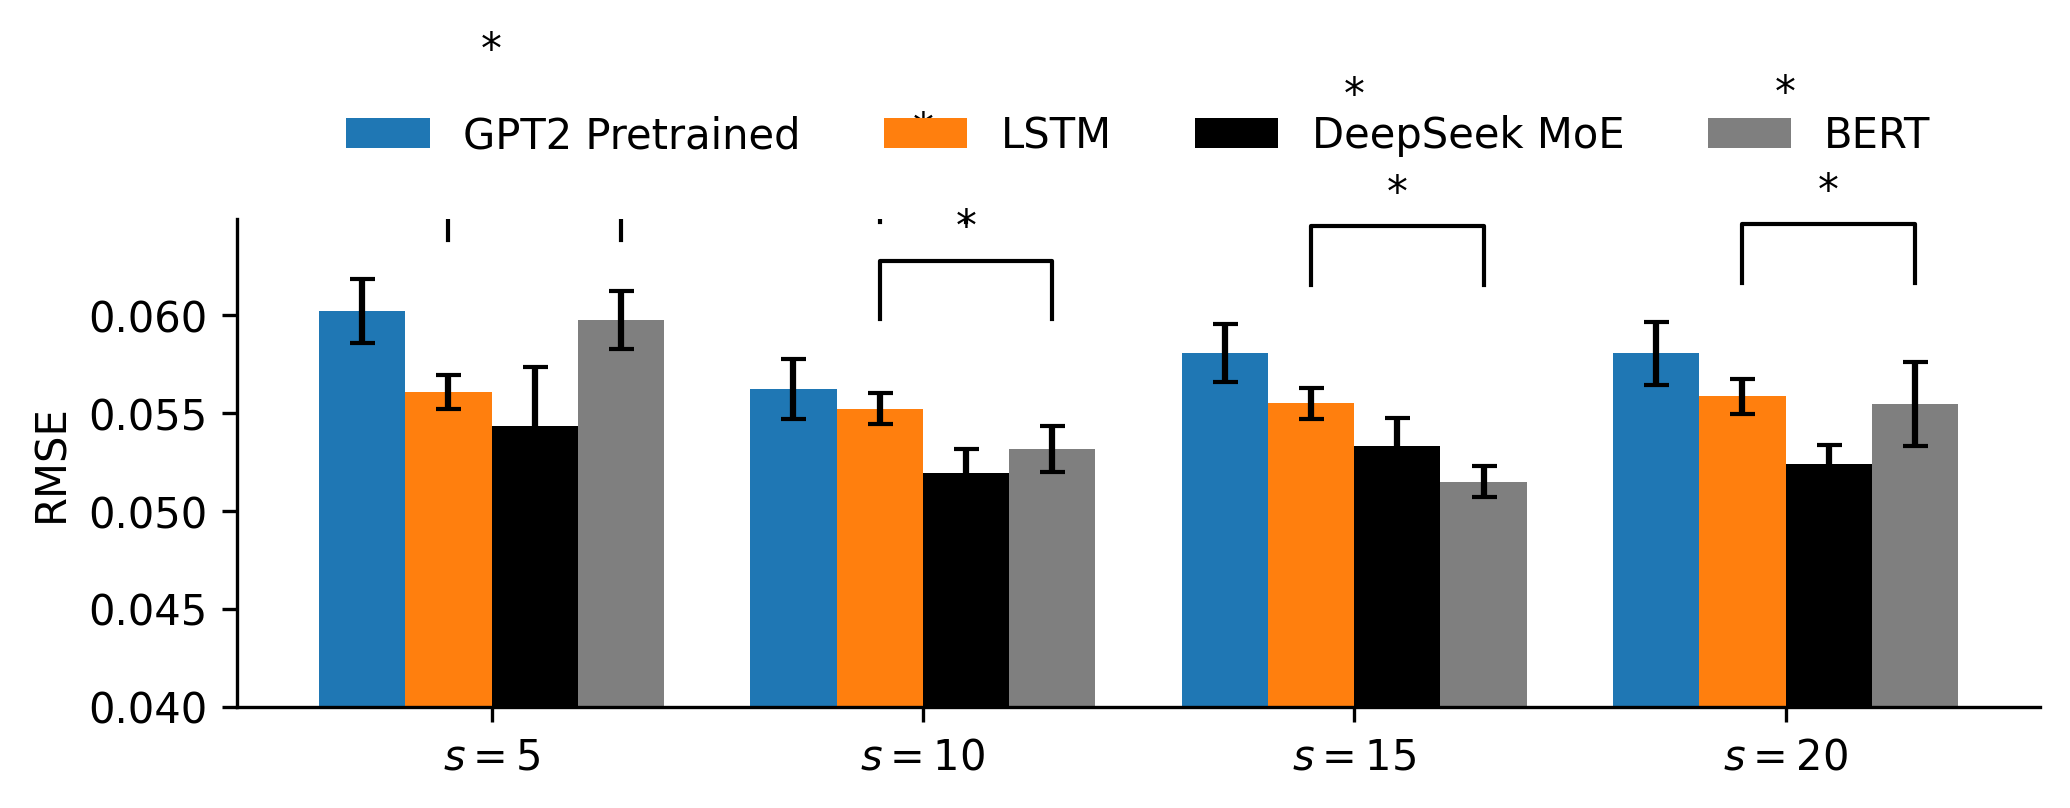

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, sem

# ----------------------------------------------------------------------
# 1) I/O settings
# ----------------------------------------------------------------------
RESULTS_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "results_april30", "experiment_1")
)

fish_list      = [9, 10, 11, 12, 13]
seq_lengths    = [5, 10, 15, 20]
num_runs       = 10

model_map = {
    "GPT2 Pretrained": ("gpt2_pretrained", "#1f77b4"),  # blue
    "LSTM"           : ("lstm",             "#ff7f0e"),  # orange
    "DeepSeek MoE"   : ("deepseek_moe",     "#000000"),  # black
    "BERT"           : ("bert",             "#7f7f7f"),  # grey
}
models_to_test = ["BERT", "DeepSeek MoE"]  # for significance vs LSTM

# ----------------------------------------------------------------------
# 2) Collect RMSE values (fish × runs)
# ----------------------------------------------------------------------
rmse_data = {m: {s: [] for s in seq_lengths} for m in model_map}

for fish in fish_list:
    y_true = np.load(os.path.join(RESULTS_ROOT,
                                  f"fish{fish}",
                                  f"fish{fish}_final_predictions_groundtruth_test.npy"))
    for run in range(1, num_runs + 1):
        for seq in seq_lengths:
            seq_dir = os.path.join(RESULTS_ROOT, f"fish{fish}", f"run_{run}", f"seq_{seq}")
            if not os.path.isdir(seq_dir):
                continue
            for m_name, (key, _) in model_map.items():
                fpath = os.path.join(seq_dir,
                                     f"fish{fish}_final_predictions_{key}_test_run{run}.npy")
                if os.path.isfile(fpath):
                    preds = np.load(fpath)
                    rmse  = np.sqrt(np.mean((preds - y_true) ** 2))
                    rmse_data[m_name][seq].append(rmse)

# ----------------------------------------------------------------------
# 3) Mean ± SEM for bars, significance tests
# ----------------------------------------------------------------------
means, errors = {}, {}
pvalues       = {seq: {} for seq in seq_lengths}

for m in model_map:
    means[m]  = [np.mean(rmse_data[m][s]) for s in seq_lengths]
    errors[m] = [sem(rmse_data[m][s])      for s in seq_lengths]

for seq in seq_lengths:
    for other in models_to_test:
        stat, p = mannwhitneyu(rmse_data["LSTM"][seq], rmse_data[other][seq],
                               alternative="two-sided")
        pvalues[seq][other] = p

# ----------------------------------------------------------------------
# 4) Plot
# ----------------------------------------------------------------------
plt.rcParams["pdf.fonttype"] = 42  # editable text in Illustrator, etc.

x           = np.arange(len(seq_lengths))
bar_w       = 0.8 / len(model_map)
fig, ax     = plt.subplots(figsize=(7, 3), dpi=300)   # wide, not tall

for i, (m, (_, color)) in enumerate(model_map.items()):
    offset = (i - len(model_map)/2) * bar_w + bar_w/2
    ax.bar(x + offset, means[m], width=bar_w,
           yerr=errors[m], capsize=3, label=m, color=color)

# y-axis formatting
ax.set_ylabel("RMSE")
ax.set_ylim(bottom=0.04)           # start y-axis at 0.04
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# x-axis labels in LaTeX style
ax.set_xticks(x)
ax.set_xticklabels([rf"$s={s}$" for s in seq_lengths])

# legend in single row above plot
ax.legend(ncol=len(model_map), frameon=False, bbox_to_anchor=(0, 1.05, 1, 0),
          loc="lower center")

# ----------------------------------------------------------------------
# 5) Significance brackets (LSTM vs BERT, LSTM vs DeepSeek)
# ----------------------------------------------------------------------
def add_sig_bracket(x1, x2, y, h, p_val):
    """Draw a bracket with star if p<0.05."""
    bar_x = [x1, x1, x2, x2]
    bar_y = [y,  y+h, y+h, y]
    ax.plot(bar_x, bar_y, color='k', linewidth=1)
    if p_val < 0.05:
        ax.text((x1+x2)/2, y+h*1.2, "*", ha='center', va='bottom', fontsize=10)

h   = 0.003   # bracket height
gap = 0.002   # gap above tallest bar

for j, seq in enumerate(seq_lengths):
    # tallest bar at this sequence length to place bracket above
    ymax = max(means[m][j] + errors[m][j] for m in model_map)
    y0   = ymax + gap
    # LSTM index in group
    idx_lstm     = list(model_map.keys()).index("LSTM")
    x_lstm       = x[j] + ((idx_lstm - len(model_map)/2) * bar_w + bar_w/2)
    for other in models_to_test:
        idx_o      = list(model_map.keys()).index(other)
        x_other    = x[j] + ((idx_o - len(model_map)/2) * bar_w + bar_w/2)
        add_sig_bracket(x_lstm, x_other, y0, h, pvalues[seq][other])
        y0 += h + gap  # stack brackets if two

plt.tight_layout()
out_file = os.path.join(RESULTS_ROOT, "experiment1_rmse_sig.pdf")
plt.savefig(out_file, dpi=300, bbox_inches="tight")
print(f"Saved figure to {out_file}")


Models used: GPT-2 (base), LSTM, DeepSeek-coder-7b, BERT-small
Saved to C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_1\experiment1_rmse_sig_final.pdf


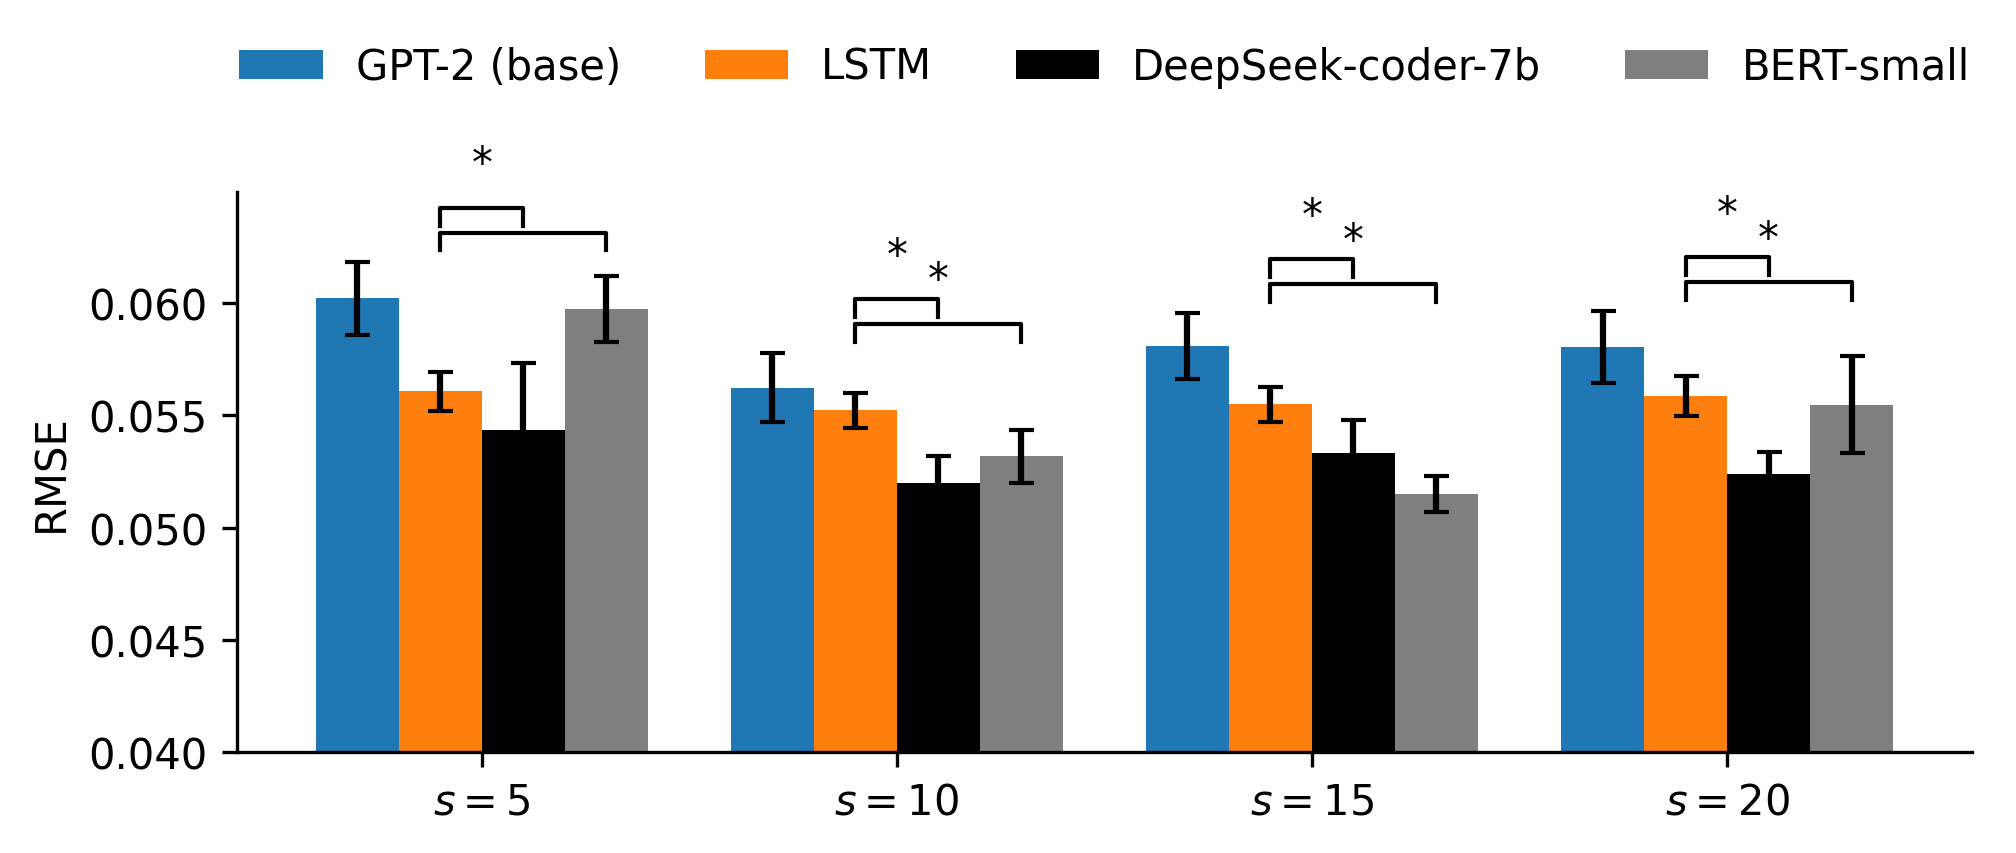

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, sem

# 1) I/O settings
RESULTS_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "results_april30", "experiment_1")
)
fish_list   = [9, 10, 11, 12, 13]
seq_lengths = [5, 10, 15, 20]
num_runs    = 10

# 2) Exact model names and mapping to file keys + colors
model_map = {
    "GPT-2 (base)":            ("gpt2_pretrained",   "#1f77b4"),
    "LSTM": ("lstm",              "#ff7f0e"),
    "DeepSeek-coder-7b":   ("deepseek_moe",      "#000000"),
    "BERT-small":   ("bert",              "#7f7f7f"),
}
model_names = list(model_map.keys())
print("Models used:", ", ".join(model_names))

# 3) Collect RMSEs
rmse_data = {m: {s: [] for s in seq_lengths} for m in model_names}

for fish in fish_list:
    gt_path = os.path.join(RESULTS_ROOT, f"fish{fish}", f"fish{fish}_final_predictions_groundtruth_test.npy")
    y_true  = np.load(gt_path)
    for run in range(1, num_runs+1):
        for seq in seq_lengths:
            seq_dir = os.path.join(RESULTS_ROOT, f"fish{fish}", f"run_{run}", f"seq_{seq}")
            if not os.path.isdir(seq_dir):
                continue
            for m in model_names:
                key = model_map[m][0]
                f   = os.path.join(seq_dir, f"fish{fish}_final_predictions_{key}_test_run{run}.npy")
                if os.path.isfile(f):
                    preds = np.load(f)
                    rmse  = np.sqrt(np.mean((preds - y_true)**2))
                    rmse_data[m][seq].append(rmse)

# 4) Compute means, SEMs, and p-values for LSTM vs BERT-small, DeepSeek
means, errs, pvals = {}, {}, {}
for m in model_names:
    means[m] = [np.mean(rmse_data[m][s]) for s in seq_lengths]
    errs[m]  = [sem(rmse_data[m][s])      for s in seq_lengths]

for seq in seq_lengths:
    lstm_vals = rmse_data["LSTM"][seq]
    pvals[seq] = {}
    for other in ["BERT-small", "DeepSeek-coder-7b"]:
        stat, p = mannwhitneyu(lstm_vals, rmse_data[other][seq], alternative="two-sided")
        pvals[seq][other] = p

# 5) Compute a per‐group base height for each sequence length
gap     = 0.0005
h       = 0.0008   # bracket vertical thickness
y_bases = [
    max(means[m][j] + errs[m][j] for m in model_names) + gap
    for j in range(len(seq_lengths))
]

# 6) Plot
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(7, 3), dpi=300)

x  = np.arange(len(seq_lengths))
bw = 0.8 / len(model_names)

for idx, m in enumerate(model_names):
    off = (idx - len(model_names)/2) * bw + bw/2
    ax.bar(x + off,
           means[m],
           width   = bw,
           yerr    = errs[m],
           capsize = 3,
           label   = m,
           color   = model_map[m][1])

ax.set_ylim(0.04, None)
ax.set_ylabel("RMSE")
ax.set_xticks(x)
ax.set_xticklabels([f"$s={s}$" for s in seq_lengths])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(ncol=len(model_names),
          frameon=False,
          bbox_to_anchor=(0, 1.12, 1, 0),
          loc="lower center")

def draw_bracket(x1, x2, y, h, p):
    # draw the little “┏━┓” bracket
    ax.plot([x1, x1, x2, x2],
            [y, y+h, y+h, y],
            lw=1, c="k")
    # star at exact midpoint
    if p < 0.05:
        ax.text((x1 + x2) / 2,
                y + h + 0.001,
                "*",
                ha="center",
                va="bottom",
                fontsize=10)

for j, seq in enumerate(seq_lengths):
    # get the baseline height for this sequence
    y_base = y_bases[j]

    # compute each bar’s center x‐position
    idx_l = model_names.index("LSTM")
    idx_b = model_names.index("BERT-small")
    idx_d = model_names.index("DeepSeek-coder-7b")

    x_l = x[j] + ((idx_l - len(model_names)/2) * bw + bw/2)
    x_b = x[j] + ((idx_b - len(model_names)/2) * bw + bw/2)
    x_d = x[j] + ((idx_d - len(model_names)/2) * bw + bw/2)

    # draw the two comparisons, using the same y_base so stars are equally high
    draw_bracket(x_l, x_b, y_base,        h, pvals[seq]["BERT-small"])
    draw_bracket(x_l, x_d, y_base + h + 0.0003, h, pvals[seq]["DeepSeek-coder-7b"])

plt.tight_layout()
out_file = os.path.join(RESULTS_ROOT, "experiment1_rmse_sig_final.pdf")
plt.savefig(out_file, dpi=300, bbox_inches="tight")
print("Saved to", out_file)


# Experiment 2

Saved to C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_2\experiment2_pretrained_vs_untrained_rmse.pdf


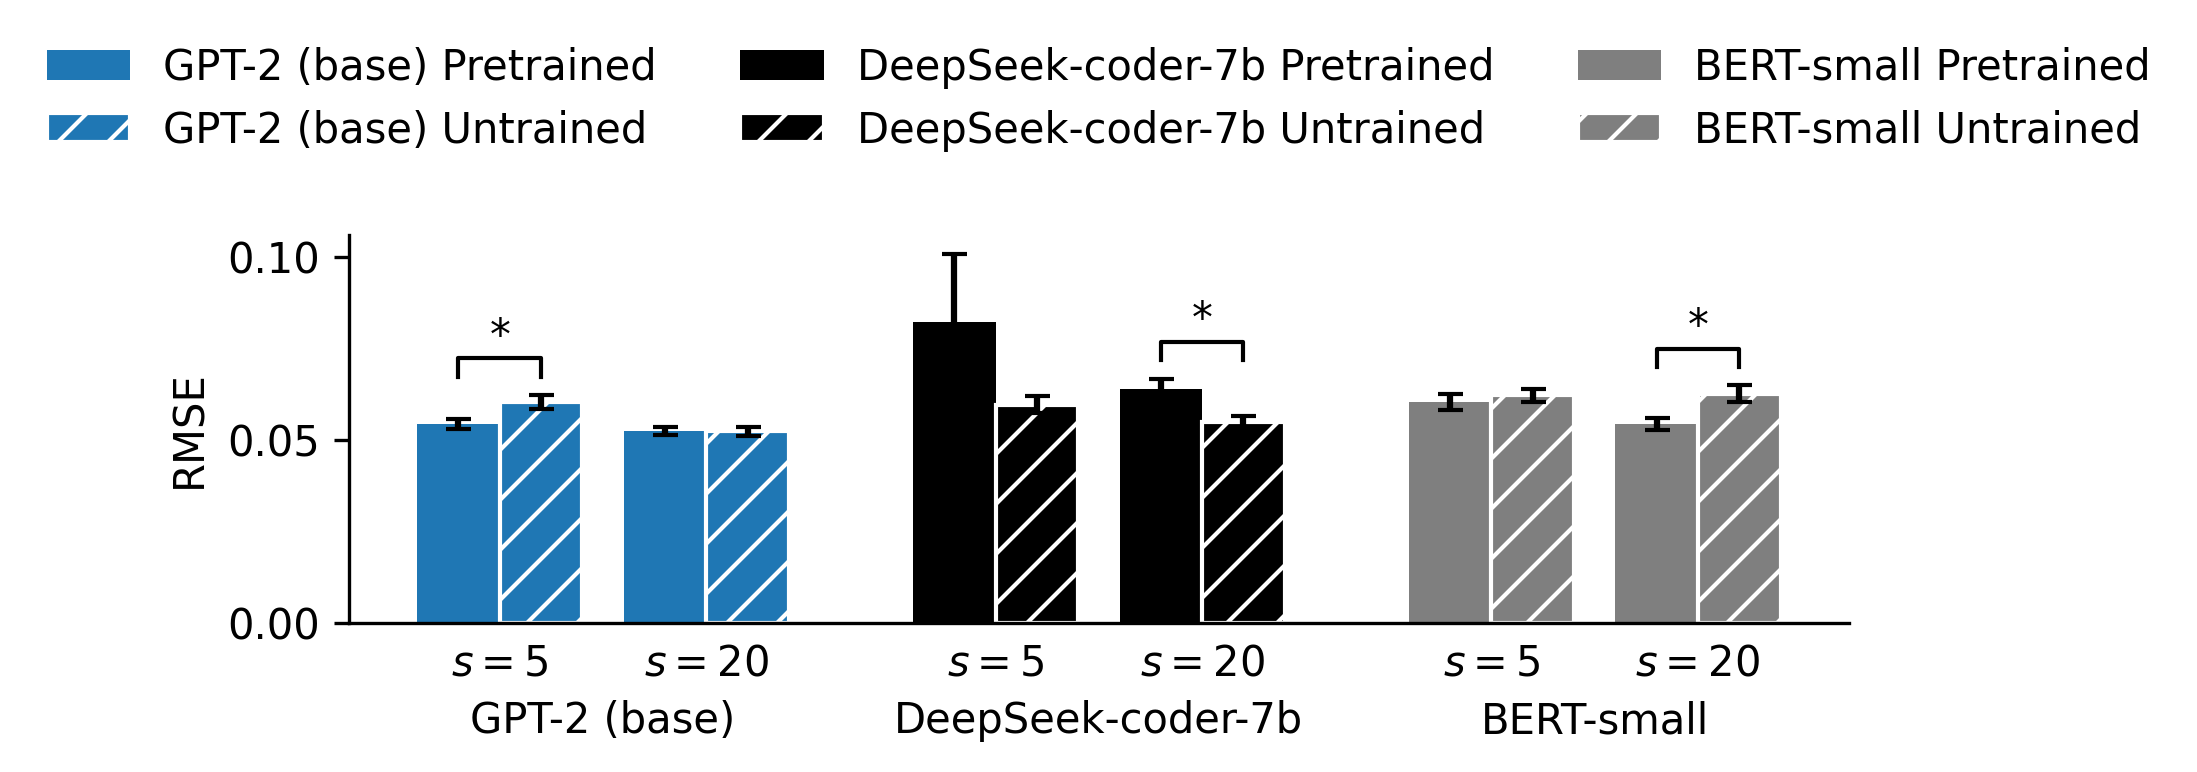

In [28]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, wilcoxon

# 0) Paths & constants
ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "results_april30", "experiment_2")
)
fish_list   = [9, 10, 11, 12, 13]
seq_lengths = [5, 20]
model_info  = {
    "GPT-2 (base)"      : {"stub": "GPT2",     "c": "#1f77b4"},
    "DeepSeek-coder-7b" : {"stub": "DeepSeek", "c": "#000000"},
    "BERT-small"        : {"stub": "BERT",     "c": "#7f7f7f"},
}
states  = {"prtr": "Pretrained", "untr": "Untrained"}

# 1) Ground‐truth loader (root or fish subfolder)
def load_gt(fid):
    for cand in (f"fish{fid}_test_groundtruth.npy",
                 f"fish{fid}_groundtruth_test.npy"):
        p = os.path.join(ROOT, cand)
        if os.path.isfile(p):
            return np.load(p)
    sub = os.path.join(ROOT, f"fish{fid}")
    for cand in (f"fish{fid}_test_groundtruth.npy",
                 f"fish{fid}_groundtruth_test.npy"):
        p = os.path.join(sub, cand)
        if os.path.isfile(p):
            return np.load(p)
    raise FileNotFoundError(f"No ground truth for fish {fid}")

# 2) Gather RMSE across fish & runs
rmse = {seq: {m: {st: [] for st in states} for m in model_info}
        for seq in seq_lengths}

for fish in fish_list:
    try:
        y_true = load_gt(fish)
    except FileNotFoundError:
        continue
    for seq in seq_lengths:
        for m, meta in model_info.items():
            for st_key, st_name in states.items():
                patt = f"fish{fish}_model_{meta['stub']}_{st_name}_run*_seq{seq}_test_preds.npy"
                for fp in glob.glob(os.path.join(ROOT, patt)):
                    pred = np.load(fp)
                    rmse_val = np.sqrt(np.mean((pred - y_true)**2))
                    rmse[seq][m][st_key].append(rmse_val)

# 3) Compute means, SEMs, and Wilcoxon p-values
means, errs, pvals = {}, {}, {}
for seq in seq_lengths:
    means[seq], errs[seq], pvals[seq] = {}, {}, {}
    for m in model_info:
        a = np.array(rmse[seq][m]["prtr"])
        b = np.array(rmse[seq][m]["untr"])
        if len(a) > 0 and len(b) > 0:
            means[seq][(m, "prtr")] = a.mean()
            errs[seq][(m, "prtr")]  = sem(a)
            means[seq][(m, "untr")] = b.mean()
            errs[seq][(m, "untr")]   = sem(b)
            pvals[seq][m]            = wilcoxon(a, b).pvalue
        else:
            means[seq][(m, "prtr")] = np.nan
            errs[seq][(m, "prtr")]  = np.nan
            means[seq][(m, "untr")] = np.nan
            errs[seq][(m, "untr")]   = np.nan
            pvals[seq][m]            = np.nan

# 4) Plot
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(7, 3), dpi=300)

bw      = 0.2
gap     = 0.05
offsets = (np.array([-1.5, -0.5, 0.5, 1.5]) * bw +
           np.array([-gap, -gap, gap, gap]))
model_names = list(model_info.keys())
centers     = np.arange(len(model_names)) * ((offsets.max() - offsets.min()) + 0.5)

seen = set()
for i, m in enumerate(model_names):
    center = centers[i]
    for j, seq in enumerate(seq_lengths):
        for k, st in enumerate(["prtr", "untr"]):
            idx = j*2 + k
            x   = center + offsets[idx]
            val = means[seq][(m, st)]
            err = errs[seq][(m, st)]
            if np.isnan(val):
                continue
            color = model_info[m]["c"]
            if st == "untr":
                hatch = "//"
                edgec = "white"
                lw    = 1
            else:
                hatch = ""
                edgec = color
                lw    = 0
            label = None
            if (m, st) not in seen:
                label = f"{m} {states[st]}"
                seen.add((m, st))
            ax.bar(x, val, yerr=err, width=bw,
                   color=color, edgecolor=edgec,
                   linewidth=lw, hatch=hatch,
                   capsize=3, label=label)

# Custom x-axis labels (two rows)
ax.set_xticks([])
for i, m in enumerate(model_names):
    center = centers[i]
    x5  = center + offsets[0:2].mean()
    x20 = center + offsets[2:4].mean()
    ax.text(x5,  -0.05, r"$s=5$",  ha="center", va="top", transform=ax.get_xaxis_transform())
    ax.text(x20, -0.05, r"$s=20$", ha="center", va="top", transform=ax.get_xaxis_transform())
    ax.text(center, -0.20, m,     ha="center", va="top", transform=ax.get_xaxis_transform())

ax.set_ylabel("RMSE")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(bottom=0)

# Legend (all bar types)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, ncol=3, frameon=False,
          bbox_to_anchor=(0.5, 1.12), loc="lower center")

# Significance brackets
def bracket(x1, x2, y, h):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], c="k", lw=1)
    ax.text((x1+x2)/2, y+h*1.05, "*", ha="center", va="bottom", fontsize=10)

h_br = 0.005
for i, m in enumerate(model_names):
    center = centers[i]
    for j, seq in enumerate(seq_lengths):
        p = pvals[seq][m]
        if p < 0.05:
            t1 = means[seq][(m, "prtr")] + errs[seq][(m, "prtr")]
            t2 = means[seq][(m, "untr")] + errs[seq][(m, "untr")]
            top = max(t1, t2)
            x1  = center + offsets[j*2]
            x2  = center + offsets[j*2+1]
            bracket(x1, x2, top + h_br, h_br)

plt.tight_layout()
outfile = os.path.join(ROOT, "experiment2_pretrained_vs_untrained_rmse.pdf")
plt.savefig(outfile, dpi=300, transparent=True, bbox_inches="tight")
print("Saved to", outfile)



# Experiment 2 (use previous pre-trained results, only add new untrained results)

Saved to C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_2\pretrained_vs_untrained_exp1_exp2.pdf


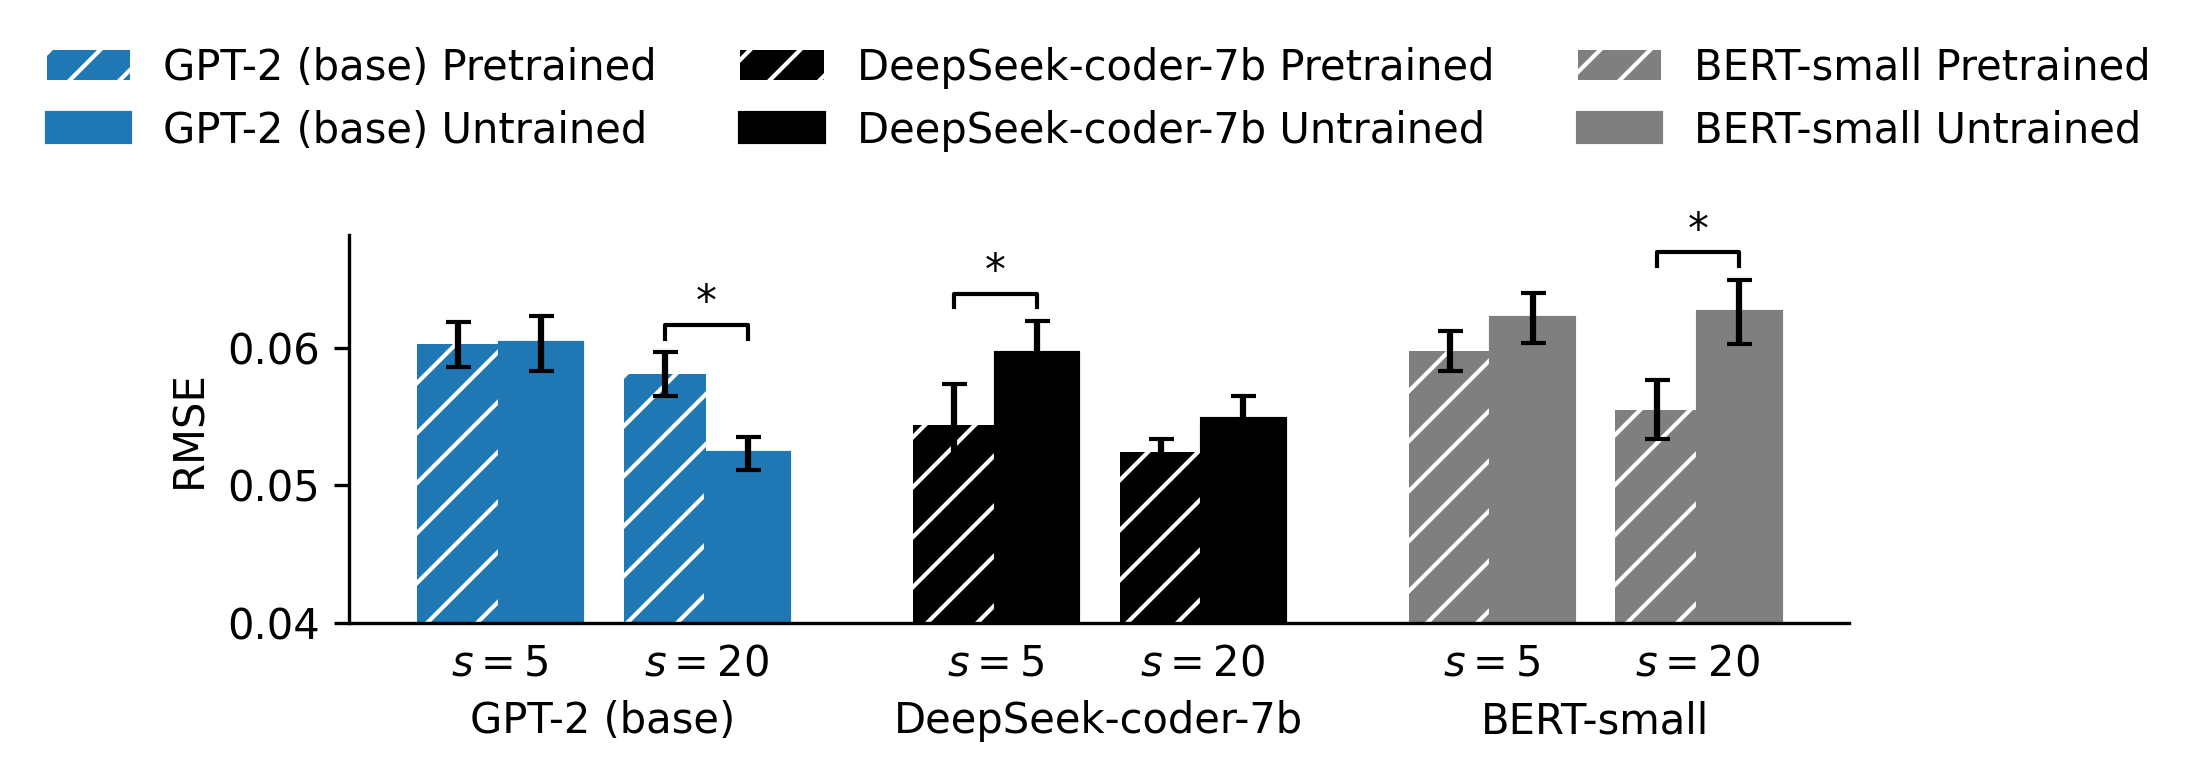

In [15]:
import os, glob, numpy as np, matplotlib.pyplot as plt
from scipy.stats import sem, wilcoxon

# ----------------------------------------------------------
# 0) paths / constants
# ----------------------------------------------------------
EXP1_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "results_april30", "experiment_1")
)
EXP2_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "results_april30", "experiment_2")
)
fish_list   = [9, 10, 11, 12, 13]
seq_lengths = [5, 20]
model_info  = {
    "GPT-2 (base)"      : dict(pre_key="gpt2_pretrained",  stub="GPT2",     c="#1f77b4"),
    "DeepSeek-coder-7b" : dict(pre_key="deepseek_moe",      stub="DeepSeek", c="#000000"),
    "BERT-small"        : dict(pre_key="bert",             stub="BERT",     c="#7f7f7f"),
}
states = {"prtr":"Pretrained", "untr":"Untrained"}

# ----------------------------------------------------------
# 1) ground-truth loader
# ----------------------------------------------------------
def load_gt(fid):
    for root in (EXP1_ROOT, EXP2_ROOT):
        for cand in (f"fish{fid}_test_groundtruth.npy",
                     f"fish{fid}_groundtruth_test.npy"):
            fp = os.path.join(root, cand)
            if os.path.isfile(fp):
                return np.load(fp)
        sub = os.path.join(root, f"fish{fid}")
        for cand in (f"fish{fid}_test_groundtruth.npy",
                     f"fish{fid}_groundtruth_test.npy"):
            fp = os.path.join(sub, cand)
            if os.path.isfile(fp):
                return np.load(fp)
    raise FileNotFoundError(f"GT fish{fid}")

# ----------------------------------------------------------
# 2) collect RMSEs
# ----------------------------------------------------------
rmse = {s:{m:{st:[] for st in states} for m in model_info} for s in seq_lengths}

for fish in fish_list:
    y_true = load_gt(fish)
    # pre-trained from exp1
    for run in range(1,11):
        for s in seq_lengths:
            seq_dir = os.path.join(EXP1_ROOT, f"fish{fish}", f"run_{run}", f"seq_{s}")
            if not os.path.isdir(seq_dir): continue
            for m,meta in model_info.items():
                f = os.path.join(seq_dir,
                     f"fish{fish}_final_predictions_{meta['pre_key']}_test_run{run}.npy")
                if os.path.isfile(f):
                    preds = np.load(f)
                    rmse_val = np.sqrt(np.mean((preds-y_true)**2))
                    rmse[s][m]["prtr"].append(rmse_val)
    # un-trained from exp2
    for run in range(1,11):
        for s in seq_lengths:
            for m,meta in model_info.items():
                f = os.path.join(EXP2_ROOT,
                     f"fish{fish}_model_{meta['stub']}_Untrained_run{run}_seq{s}_test_preds.npy")
                if os.path.isfile(f):
                    preds = np.load(f)
                    rmse_val = np.sqrt(np.mean((preds-y_true)**2))
                    rmse[s][m]["untr"].append(rmse_val)

# ----------------------------------------------------------
# 3) compute means, sem, p-values
# ----------------------------------------------------------
means, errs, pvals = {}, {}, {}
for s in seq_lengths:
    means[s], errs[s], pvals[s] = {}, {}, {}
    for m in model_info:
        a = np.array(rmse[s][m]["prtr"])
        b = np.array(rmse[s][m]["untr"])
        means[s][(m,"prtr")] = a.mean()
        errs [s][(m,"prtr")] = sem(a) if len(a)>1 else 0
        means[s][(m,"untr")] = b.mean()
        errs [s][(m,"untr")] = sem(b) if len(b)>1 else 0
        pvals[s][m] = wilcoxon(a,b).pvalue if len(a)==len(b) and len(a)>0 else np.nan

# ----------------------------------------------------------
# 4) plotting
# ----------------------------------------------------------
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(7,3), dpi=300)

bw      = 0.2
gap     = 0.05
offsets = (np.array([-1.5,-0.5,0.5,1.5])*bw + np.array([-gap,-gap,gap,gap]))
model_names = list(model_info.keys())
centers     = np.arange(len(model_names))*((offsets.max()-offsets.min())+0.5)

seen=set()
for i,m in enumerate(model_names):
    center=centers[i]
    for j,s in enumerate(seq_lengths):
        for k,st in enumerate(["prtr","untr"]):
            x = center + offsets[j*2+k]
            val = means[s][(m,st)]
            err = errs[s][(m,st)]
            if np.isnan(val): continue
            col = model_info[m]["c"]
            if st=="untr":
                hatch=""; edgec=col; lw=1
            else:
                hatch="//";  edgec="white";     lw=0
            label=None
            if (m,st) not in seen:
                label=f"{m} {states[st]}"; seen.add((m,st))
            ax.bar(x,val,yerr=err,width=bw,color=col,
                   edgecolor=edgec,linewidth=lw,hatch=hatch,
                   capsize=3,label=label)

# custom x-axis labels (two lines)
ax.set_xticks([])
for i,m in enumerate(model_names):
    center=centers[i]
    ax.text(center+offsets[:2].mean(), -0.05, r"$s=5$",  ha="center", va="top",
            transform=ax.get_xaxis_transform())
    ax.text(center+offsets[2:].mean(), -0.05, r"$s=20$", ha="center", va="top",
            transform=ax.get_xaxis_transform())
    ax.text(center, -0.20, m, ha="center", va="top",
            transform=ax.get_xaxis_transform())

ax.set_ylabel("RMSE")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylim(0.04, None)            #` <-- start at 0.04 now

# legend
h,l = ax.get_legend_handles_labels()
ax.legend(h,l,ncol=3,frameon=False,
          bbox_to_anchor=(0.5,1.12),loc="lower center")

# significance brackets
def bracket(x1,x2,y,h):
    ax.plot([x1,x1,x2,x2],[y,y+h,y+h,y],c="k",lw=1)
    ax.text((x1+x2)/2,y+h*1.05,"*",ha="center",va="bottom")

h_br=0.001
for i,m in enumerate(model_names):
    center=centers[i]
    for j,s in enumerate(seq_lengths):
        if pvals[s][m] < 0.05:
            top = max(means[s][(m,"prtr")]+errs[s][(m,"prtr")],
                      means[s][(m,"untr")]+errs[s][(m,"untr")])
            x1=center+offsets[j*2]; x2=center+offsets[j*2+1]
            bracket(x1,x2,top+h_br,h_br)

plt.tight_layout()
outfile=os.path.join(EXP2_ROOT,"pretrained_vs_untrained_exp1_exp2.pdf")
plt.savefig(outfile,dpi=300,transparent=True,bbox_inches="tight")
print("Saved to",outfile)


# Experiment 3A

In [ ]:
# bert base uncased

Saved to: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment3_results\final_plots_and_stats\all_models_embedding_comparison_with_pvalues.pdf

Pairwise Wilcoxon signed-rank p-values for each model:

Model: GPT-2 (base)
  Vanilla      vs Positional  : p = 1.0000e+00
  Vanilla      vs RelativePos : p = 1.6016e-01
  Vanilla      vs Sparse      : p = 7.6953e-01
  Vanilla      vs Spectral    : p = 1.0000e+00
  Positional   vs RelativePos : p = 3.2227e-01
  Positional   vs Sparse      : p = 6.2500e-01
  Positional   vs Spectral    : p = 7.6953e-01
  RelativePos  vs Sparse      : p = 3.2227e-01
  RelativePos  vs Spectral    : p = 6.2500e-01
  Sparse       vs Spectral    : p = 1.0000e+00

Model: DeepSeek-coder-7b
  Vanilla      vs Positional  : p = 2.7539e-01
  Vanilla      vs RelativePos : p = 7.6953e-01
  Vanilla      vs Sparse      : p = 6.2500e-01
  Vanilla      vs Spectral    : p = 2.3242e-01
  Positional   vs RelativePos : p = 6.9531e-01
  Position

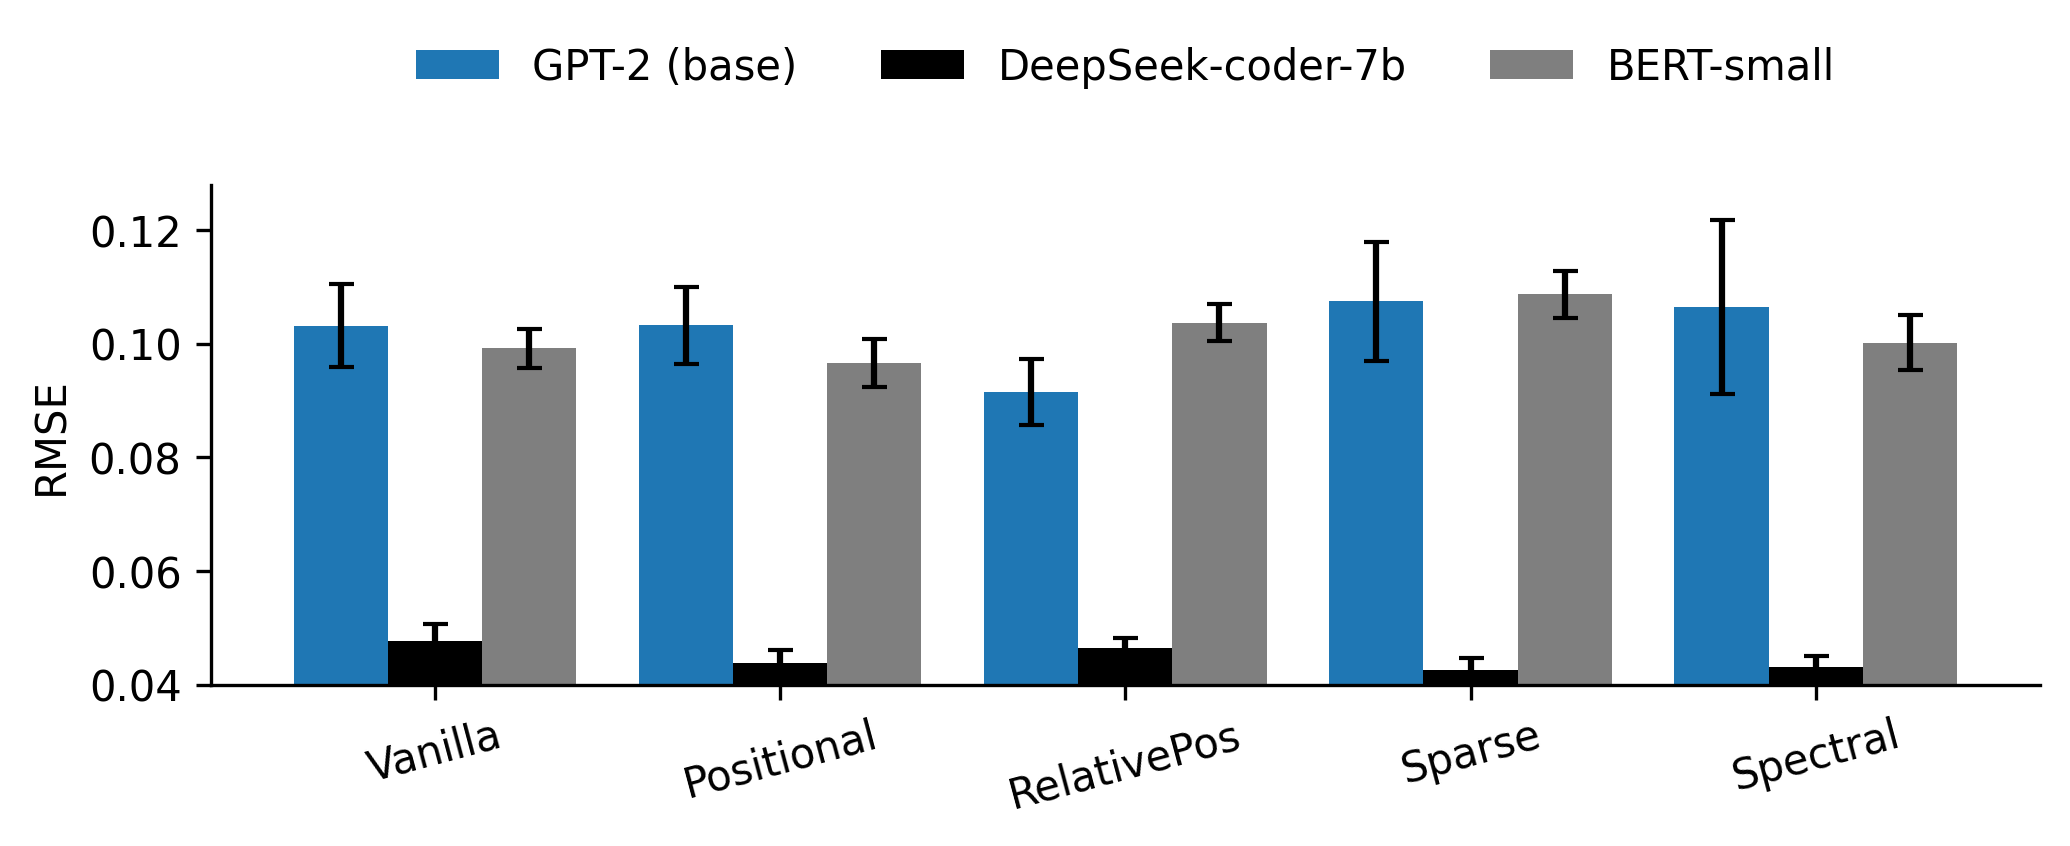

In [27]:
#!/usr/bin/env python3
import os, glob, numpy as np, matplotlib.pyplot as plt
from scipy.stats import sem, wilcoxon

# ---------------------------------------------------------------------
# 0) paths, names, colours
# ---------------------------------------------------------------------
ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "results_april30",
                 "experiment3_results")
)
RUNS       = range(1, 11)
EMB_STRATS = ["Vanilla", "Positional", "RelativePos", "Sparse", "Spectral"]
MODEL_INFO = {
    "GPT-2 (base)"      : {"stub":"gpt2",     "c":"#1f77b4"},
    "DeepSeek-coder-7b" : {"stub":"deepseek", "c":"#000000"},
    "BERT-small"        : {"stub":"bert",     "c":"#7f7f7f"},
}

# ---------------------------------------------------------------------
# 1) load ground truth
# ---------------------------------------------------------------------
for gt in ("final_predictions_groundtruth_test.npy","groundtruth_test.npy"):
    fp = os.path.join(ROOT, gt)
    if os.path.isfile(fp):
        y_true = np.load(fp)
        break
else:
    raise FileNotFoundError("ground-truth test array not found")

# ---------------------------------------------------------------------
# 2) gather RMSEs
# ---------------------------------------------------------------------
rmse = {e:{m:[] for m in MODEL_INFO} for e in EMB_STRATS}

for run in RUNS:
    run_dir = os.path.join(ROOT, f"run_{run}")
    if not os.path.isdir(run_dir): continue
    for m,info in MODEL_INFO.items():
        fam_dir = os.path.join(run_dir, f"{info['stub']}_embedding_comparisons")
        for emb in EMB_STRATS:
            pred_fp = os.path.join(
                fam_dir,
                emb.lower(),
                f"{info['stub']}_{emb.lower()}_preds_run{run}.npy"
            )
            if os.path.isfile(pred_fp):
                preds = np.load(pred_fp)
                rmse_val = np.sqrt(np.mean((preds - y_true)**2))
                rmse[emb][m].append(rmse_val)

# ---------------------------------------------------------------------
# 3) compute means, SEMs, and Wilcoxon p-values vs. Vanilla
# ---------------------------------------------------------------------
means = {e:[np.mean(rmse[e][m]) for m in MODEL_INFO] for e in EMB_STRATS}
errs  = {e:[sem (rmse[e][m])    for m in MODEL_INFO] for e in EMB_STRATS}

pvals = {m:{} for m in MODEL_INFO}
for m in MODEL_INFO:
    base = np.array(rmse["Vanilla"][m])
    for emb in EMB_STRATS[1:]:
        comp = np.array(rmse[emb][m])
        if len(base)==len(comp) and len(base)>0:
            pvals[m][emb] = wilcoxon(base,comp).pvalue
        else:
            pvals[m][emb] = np.nan

# ---------------------------------------------------------------------
# 4) plot
# ---------------------------------------------------------------------
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(7,3), dpi=300)

bw   = 0.18
gap  = 0.12
xgrp = np.arange(len(EMB_STRATS)) * (3*bw + gap)
models = list(MODEL_INFO.keys())

# draw bars
for j, m in enumerate(models):
    x_off = -bw + j*bw
    xs    = xgrp + x_off
    ys    = [means[e][j] for e in EMB_STRATS]
    es    = [errs [e][j] for e in EMB_STRATS]
    ax.bar(xs, ys, yerr=es, width=bw, capsize=3,
           color=MODEL_INFO[m]["c"], edgecolor=MODEL_INFO[m]["c"],
           linewidth=0, label=m)

ax.set_ylabel("RMSE")
ax.set_ylim(0.04, None)
ax.set_xticks(xgrp)
ax.set_xticklabels(EMB_STRATS, rotation=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(ncol=3, frameon=False,
          bbox_to_anchor=(0.5,1.12), loc="lower center")

# ---------------------------------------------------------------------
# 5) brackets + print p-values
# ---------------------------------------------------------------------
def bracket(x1, x2, y, h, p):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], c="k", lw=1)
    txt = f"p={p:.2e}"
    ax.text((x1+x2)/2, y + h*1.1, txt, ha="center", va="bottom", fontsize=8)

h_gap = 0.002
for j, m in enumerate(models):
    base_x = xgrp[0] + (-bw + j*bw)
    base_top = means["Vanilla"][j] + errs["Vanilla"][j]
    for k, emb in enumerate(EMB_STRATS[1:], start=1):
        p = pvals[m][emb]
        if not np.isnan(p) and p < 0.05:
            other_x   = xgrp[k] + (-bw + j*bw)
            other_top = means[emb][j] + errs[emb][j]
            y0 = max(base_top, other_top) + h_gap
            bracket(base_x, other_x, y0, h_gap, p)

plt.tight_layout()
out = os.path.join(
    ROOT, "final_plots_and_stats",
    "all_models_embedding_comparison_with_pvalues.pdf"
)
plt.savefig(out, dpi=300, transparent=True, bbox_inches="tight")
print("Saved to:", out)

from scipy.stats import wilcoxon

print("\nPairwise Wilcoxon signed-rank p-values for each model:\n")
for model in MODEL_INFO:
    print(f"Model: {model}")
    for i in range(len(EMB_STRATS)):
        for j in range(i+1, len(EMB_STRATS)):
            e1, e2 = EMB_STRATS[i], EMB_STRATS[j]
            data1 = rmse[e1][model]
            data2 = rmse[e2][model]
            if len(data1)==len(data2) and len(data1)>0:
                stat, p = wilcoxon(data1, data2)
                print(f"  {e1:12s} vs {e2:12s}: p = {p:.4e}")
            else:
                print(f"  {e1:12s} vs {e2:12s}: insufficient paired runs")
    print()



# Let's try across all models


Pairwise Wilcoxon signed-rank p-values (pooled across models):
Vanilla      vs Positional  : p = 4.5216e-01
Vanilla      vs RelativePos : p = 3.5988e-01
Vanilla      vs Sparse      : p = 6.4083e-01
Vanilla      vs Spectral    : p = 5.4253e-01
Positional   vs RelativePos : p = 8.7121e-01
Positional   vs Sparse      : p = 1.7060e-01
Positional   vs Spectral    : p = 8.0783e-01
RelativePos  vs Sparse      : p = 3.3874e-01
RelativePos  vs Spectral    : p = 6.1201e-01
Sparse       vs Spectral    : p = 5.8376e-01
Saved plot to: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment3_results\final_plots_and_stats\embeddings_pooled_models.pdf


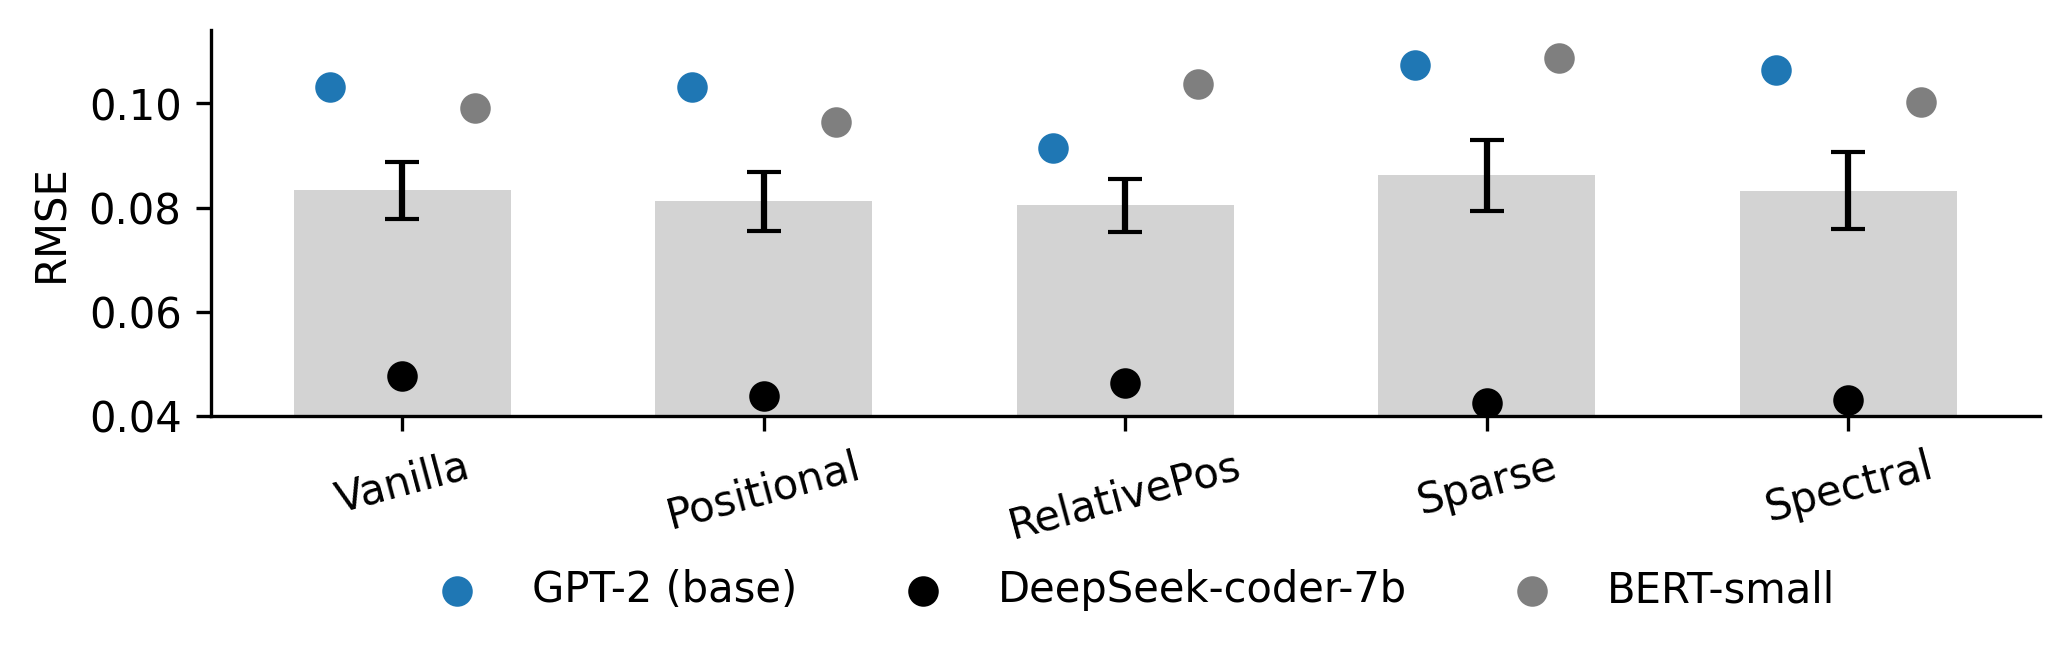

In [58]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem, wilcoxon

# ---------------------------------------------------------------------
# 0) paths, names, colours
# ---------------------------------------------------------------------
ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "results_april30",
                 "experiment3_results")
)
RUNS       = range(1, 11)
EMB_STRATS = ["Vanilla", "Positional", "RelativePos", "Sparse", "Spectral"]
MODEL_INFO = {
    "GPT-2 (base)"      : {"stub":"gpt2",     "c":"#1f77b4"},
    "DeepSeek-coder-7b" : {"stub":"deepseek", "c":"#000000"},
    "BERT-small"        : {"stub":"bert",     "c":"#7f7f7f"},
}

# ---------------------------------------------------------------------
# 1) load ground truth
# ---------------------------------------------------------------------
for gt in ("final_predictions_groundtruth_test.npy","groundtruth_test.npy"):
    fp = os.path.join(ROOT, gt)
    if os.path.isfile(fp):
        y_true = np.load(fp)
        break
else:
    raise FileNotFoundError("ground-truth test array not found")

# ---------------------------------------------------------------------
# 2) gather RMSEs per embedding, per model
# ---------------------------------------------------------------------
rmse = {emb: {m: [] for m in MODEL_INFO} for emb in EMB_STRATS}

for run in RUNS:
    run_dir = os.path.join(ROOT, f"run_{run}")
    if not os.path.isdir(run_dir): 
        continue
    for m, info in MODEL_INFO.items():
        fam_dir = os.path.join(run_dir, f"{info['stub']}_embedding_comparisons")
        for emb in EMB_STRATS:
            pred_fp = os.path.join(
                fam_dir,
                emb.lower(),
                f"{info['stub']}_{emb.lower()}_preds_run{run}.npy"
            )
            if os.path.isfile(pred_fp):
                preds = np.load(pred_fp)
                rmse_val = np.sqrt(np.mean((preds - y_true)**2))
                rmse[emb][m].append(rmse_val)

# ---------------------------------------------------------------------
# 3) pool across models for each embedding
# ---------------------------------------------------------------------
pooled = {emb: np.concatenate([rmse[emb][m] for m in MODEL_INFO]) for emb in EMB_STRATS}

# compute pooled means and SEMs
pooled_means = {emb: pooled[emb].mean() for emb in EMB_STRATS}
pooled_sems  = {emb: sem(pooled[emb])       for emb in EMB_STRATS}

# compute model-specific means per embedding
model_means = {
    emb: {m: np.mean(rmse[emb][m]) for m in MODEL_INFO}
    for emb in EMB_STRATS
}

# ---------------------------------------------------------------------
# 4) plot bars + staggered circles
# ---------------------------------------------------------------------
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(7, 2.5), dpi=300)

x = np.arange(len(EMB_STRATS))
bw = 0.6
# draw pooled bars
ax.bar(x, [pooled_means[e] for e in EMB_STRATS],
       yerr=[pooled_sems[e] for e in EMB_STRATS],
       capsize=4, width=bw, color="lightgray", edgecolor="none")

# draw model-specific means as colored circles
n_models = len(MODEL_INFO)
offsets = np.linspace(-bw/3, bw/3, n_models)
for j, (m, info) in enumerate(MODEL_INFO.items()):
    xs = x + offsets[j]
    ys = [model_means[emb][m] for emb in EMB_STRATS]
    ax.scatter(xs, ys, color=info["c"], label=m, zorder=5, s=40)

# styling
ax.set_xticks(x)
ax.set_xticklabels(EMB_STRATS, rotation=15)
ax.set_ylim(0.04, None)
ax.set_ylabel("RMSE")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)

# legend for models
# make room at the bottom for the legend
fig.subplots_adjust(bottom=0.09)

# place the legend below the plot in one row
ax.legend(
    ncol=len(MODEL_INFO),
    frameon=False,
    bbox_to_anchor=(0.5, -0.3),
    loc="upper center"
)
# ax.legend(ncol=3, frameon=False, bbox_to_anchor=(0.5, 1.12), loc="lower center")

# ---------------------------------------------------------------------
# 5) significance tests across embeddings (pooled data)
# ---------------------------------------------------------------------
print("\nPairwise Wilcoxon signed-rank p-values (pooled across models):")
for i in range(len(EMB_STRATS)):
    for j in range(i+1, len(EMB_STRATS)):
        e1, e2 = EMB_STRATS[i], EMB_STRATS[j]
        data1, data2 = pooled[e1], pooled[e2]
        if len(data1)==len(data2) and len(data1)>0:
            stat, p = wilcoxon(data1, data2)
            print(f"{e1:12s} vs {e2:12s}: p = {p:.4e}")
        else:
            print(f"{e1:12s} vs {e2:12s}: insufficient data")

# save
out = os.path.join(ROOT, "final_plots_and_stats",
                   "embeddings_pooled_models.pdf")
plt.tight_layout()
plt.savefig(out, dpi=300, transparent=True, bbox_inches="tight")
print("Saved plot to:", out)



# Experiment 3b

Figure saved to: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment3b_results\final_plots_and_stats\embeddings_all_vs_top50_removed.pdf

Wilcoxon signed-rank p-values  (all  vs  top-50-removed)
Vanilla     :  p = 7.922e-01
Positional  :  p = 7.151e-01
RelativePos :  p = 4.726e-02
Sparse      :  p = 1.909e-01
Spectral    :  p = 6.554e-01


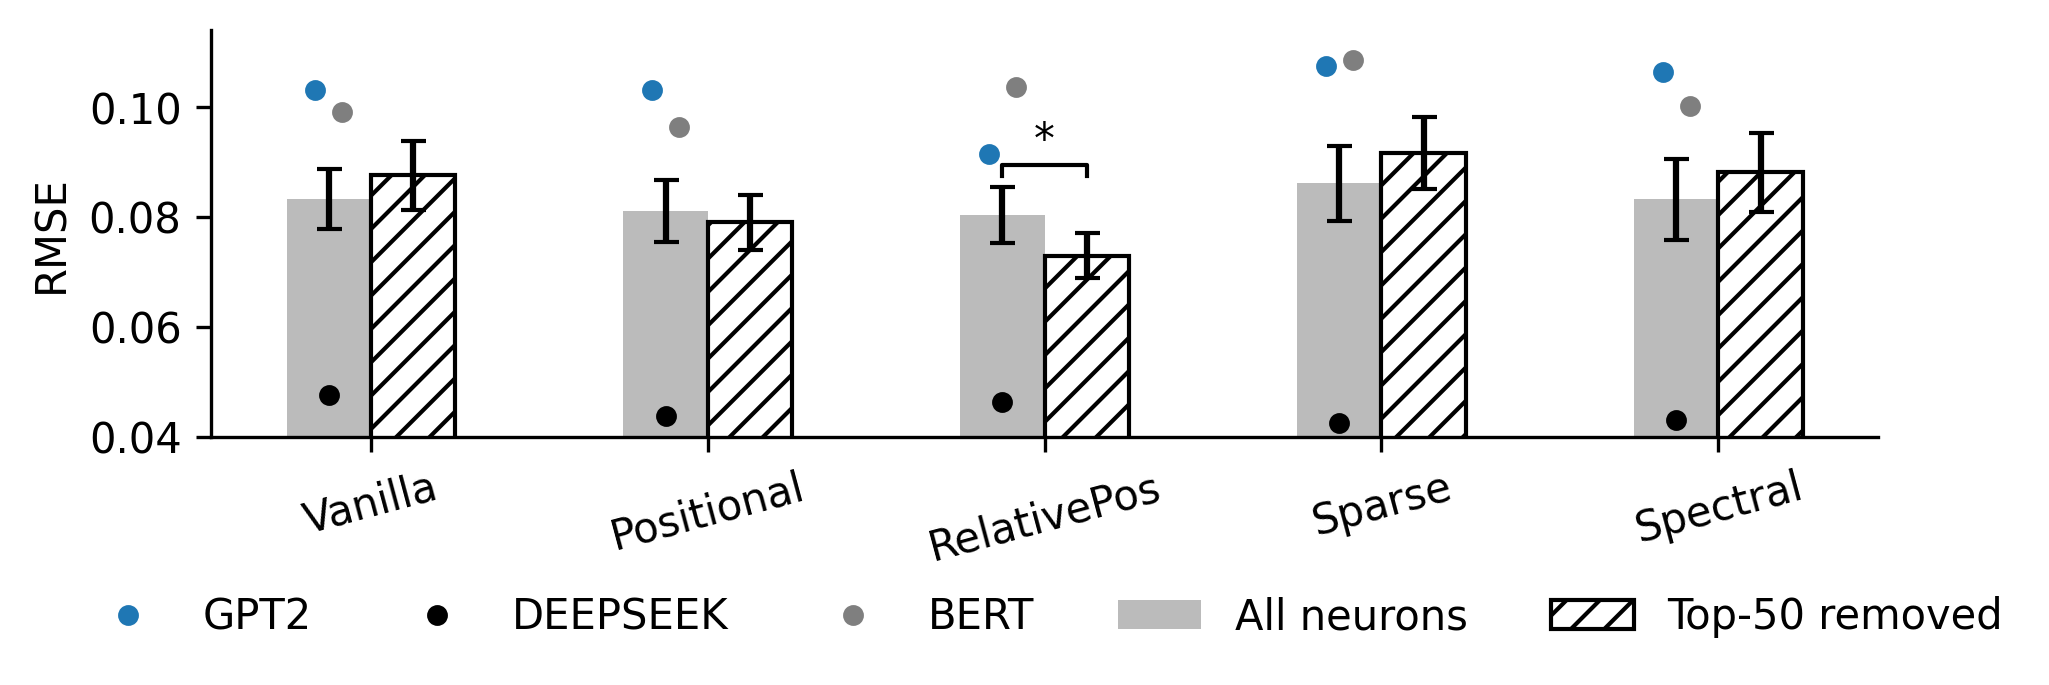

In [62]:
#!/usr/bin/env python3
# ------------------------------------------------------------------
#  BAR-PLOT:  All neurons  vs.  Top-50-removed
#             pooled across models for each embedding strategy
# ------------------------------------------------------------------
import os, glob, numpy as np, matplotlib.pyplot as plt
from scipy.stats import wilcoxon, sem

plt.rcParams["pdf.fonttype"] = 42   # editable text in PDF

# ------------------------------------------------------------------
# 0)  paths & constants
# ------------------------------------------------------------------
ROOT_A = os.path.abspath(       # experiment3_results  (all neurons)
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro",
                 "results_april30", "experiment3_results")
)
ROOT_B = os.path.abspath(       # experiment3b_results/top50_removed
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro",
                 "results_april30", "experiment3b_results")
)
SUB_B  = "top50_removed"        # choice: “top50_removed” vs “random50_removed”

EMBEDS  = ["Vanilla", "Positional", "RelativePos",
           "Sparse",  "Spectral"]
MODELS  = ["gpt2", "deepseek", "bert"]          # lowercase stub in file paths
RUNS    = range(1, 11)                          # 1 … 10

# colour / marker per model for the scatter overlay
COLORS = dict(gpt2="#1f77b4", deepseek="#000000", bert="#7f7f7f")
SHIFT  = [-0.04, 0.0, 0.04]                     # small x-jitter for circles

# ------------------------------------------------------------------
# 1) helper: collect RMSEs from a root (A or B)
# ------------------------------------------------------------------
def load_pool(root_dir, subfolder=None):
    """
    Return dict[embed] -> list of RMSEs  pooled over models and runs.
    """
    pool = {e: [] for e in EMBEDS}
    for run in RUNS:
        run_dir = os.path.join(root_dir,
                               (subfolder if subfolder else f"run_{run}"))
        if subfolder:    # experiment3b: ROOT_B/top50_removed/run_X
            run_dir = os.path.join(root_dir, subfolder, f"run_{run}")

        for model in MODELS:
            fam_dir = os.path.join(run_dir, f"{model}_embedding_comparisons")
            for emb in EMBEDS:
                e_low = emb.lower()
                emb_dir = os.path.join(fam_dir, e_low)
                if not os.path.isdir(emb_dir):
                    continue
                # predictions & ground-truth
                preds_glob = glob.glob(os.path.join(
                    emb_dir, f"{model}_{e_low}_preds_run{run}.npy"))
                if len(preds_glob) != 1:
                    continue
                preds = np.load(preds_glob[0])
                gt_path = os.path.join(
                    emb_dir, f"{model}_{e_low}_groundtruth.npy")
                y_true = np.load(gt_path) if os.path.isfile(gt_path) \
                         else np.load(os.path.join(root_dir,
                                         "groundtruth_test.npy"))
                rmse = np.sqrt(np.mean((preds - y_true) ** 2))
                pool[emb].append(rmse)
    return pool

pool_all  = load_pool(ROOT_A)                          # experiment 3
pool_top  = load_pool(ROOT_B, subfolder=SUB_B)         # experiment 3b

# ------------------------------------------------------------------
# 2)  compute stats
# ------------------------------------------------------------------
means_all = [np.mean(pool_all[e]) for e in EMBEDS]
errs_all  = [sem( pool_all[e])    for e in EMBEDS]
means_top = [np.mean(pool_top[e]) for e in EMBEDS]
errs_top  = [sem( pool_top[e])    for e in EMBEDS]

p_vals = {e: wilcoxon(pool_all[e], pool_top[e]).pvalue
          for e in EMBEDS}

# ------------------------------------------------------------------
# 3)  plotting
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 1.5), dpi=300)

x = np.arange(len(EMBEDS))
bw = 0.25

# baseline bars (all neurons)
ax.bar(x - bw/2, means_all, yerr=errs_all, width=bw,
       color="#bbbbbb", label="All neurons", capsize=3)

# top-50-removed bars (hatched)
ax.bar(x + bw/2, means_top, yerr=errs_top, width=bw,
       color="#ffffff", edgecolor="#000000", linewidth=1,
       hatch="///", label="Top-50 removed", capsize=3)

# overlay model means as coloured circles
for m_idx, model in enumerate(MODELS):
    col = COLORS[model]
    for e_idx, emb in enumerate(EMBEDS):
        # mean for this model & embedding in each condition
        #   — show only the “all neurons” circle to avoid clutter
        model_vals = []
        for run in RUNS:
            run_dir = os.path.join(ROOT_A, f"run_{run}",
                        f"{model}_embedding_comparisons", emb.lower())
            p = glob.glob(os.path.join(run_dir,
                         f"{model}_{emb.lower()}_preds_run{run}.npy"))
            if len(p) != 1: continue
            preds = np.load(p[0])
            y_true = np.load(os.path.join(run_dir,
                         f"{model}_{emb.lower()}_groundtruth.npy"))
            model_vals.append(np.sqrt(np.mean((preds - y_true) ** 2)))
        if model_vals:
            ax.plot(e_idx - bw/2 + SHIFT[m_idx],
                    np.mean(model_vals), "o", color=col, markersize=4,
                    label=model.upper() if e_idx==0 else None)

# aesthetics
ax.set_xticks(x)
ax.set_xticklabels(EMBEDS, rotation=15)
ax.set_ylabel("RMSE")
ax.set_ylim(0.04, None)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# significance bracket
h = 0.002
pad = 0.0005
for e_idx, emb in enumerate(EMBEDS):
    if p_vals[emb] < 0.05:
        y0 = max(means_all[e_idx] + errs_all[e_idx],
                 means_top[e_idx] + errs_top[e_idx]) + h
        x0 = e_idx - bw/2
        x1 = e_idx + bw/2
        ax.plot([x0, x0, x1, x1],
                [y0, y0 + h, y0 + h, y0],
                color='k', lw=1)
        ax.text(e_idx, y0 + h + pad,
                '*', ha='center', va='bottom', fontsize=10)

# legend below
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,
          ncol=5, frameon=False,
          loc='upper center',
          bbox_to_anchor=(0.5, -0.35),
          borderaxespad=0.)

plt.tight_layout()
plt.subplots_adjust(bottom=-0.005)
out_pdf = os.path.join(ROOT_B, "final_plots_and_stats",
                       "embeddings_all_vs_top50_removed.pdf")
plt.savefig(out_pdf, dpi=300, transparent=True, bbox_inches="tight")
print("Figure saved to:", out_pdf)

# ------------------------------------------------------------------
# 4)  print p-values
# ------------------------------------------------------------------
print("\nWilcoxon signed-rank p-values  (all  vs  top-50-removed)")
for emb in EMBEDS:
    print(f"{emb:12s}:  p = {p_vals[emb]:.3e}")


# PCA of embeddings 

In [53]:
#!/usr/bin/env python3
# ---------------------------------------------------------------
#  PCA visualisation of 5 neural-token embeddings
#  (Vanilla • Positional • RelativePos • SparseAE • Spectral)
#  – Saves transparent PDFs with a shorter colour-bar
# ---------------------------------------------------------------
import os, math, numpy as np, torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec

# ============  0) Where to save  ================================
RESULTS_DIR = os.path.join(os.getcwd(), "experiment_3")
os.makedirs(RESULTS_DIR, exist_ok=True)

# ============  1) Embedding classes  ============================
class VanillaLinearEmbedding(nn.Module):
    def __init__(self, in_dim, h): super().__init__(); self.l = nn.Linear(in_dim, h)
    def forward(self, x): return self.l(x)

class PositionalLinearEmbedding(nn.Module):
    def __init__(self, in_dim, h, max_len=1024):
        super().__init__()
        self.l = nn.Linear(in_dim, h)
        self.register_buffer('pe', self._build(max_len, h), persistent=False)
    def _build(self, L, h):
        pe  = torch.zeros(L, h)
        pos = torch.arange(0, L).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, h, 2).float() * (-math.log(10000.0) / h))
        pe[:, 0::2], pe[:, 1::2] = torch.sin(pos * div), torch.cos(pos * div)
        return pe.unsqueeze(0)                                        # (1,L,h)
    def forward(self, x):
        x = self.l(x)
        return x + self.pe[:, :x.size(1)]

class RelativePositionEmbedding(nn.Module):
    """ Trainable relative-position bias (distance clip ±max_dist). """
    def __init__(self, in_dim, h, max_dist=32):
        super().__init__()
        self.l   = nn.Linear(in_dim, h)
        self.max = max_dist
        self.rel = nn.Embedding(2 * max_dist + 1, h)
    def forward(self, x):
        x = self.l(x)                                                 # (B,L,h)
        B, L, _ = x.shape
        offs = torch.arange(L, device=x.device) - torch.arange(L, device=x.device)[0]
        offs = offs.clamp(-self.max, self.max) + self.max            # shift to [0..2*max]
        bias = self.rel(offs).unsqueeze(0).expand(B, L, -1)
        return x + bias

class SparseAutoencoderEmbedding(nn.Module):
    def __init__(self, in_dim, h):
        super().__init__()
        self.enc = nn.Linear(in_dim, h); self.dec = nn.Linear(h, in_dim)
        self.act = nn.ReLU()
    def forward(self, x):
        B, L, _ = x.shape
        flat = x.reshape(B * L, -1)
        enc  = self.act(self.enc(flat)).view(B, L, -1)
        return enc                                                    # decoder unused

class SpectralEmbedding(nn.Module):
    def __init__(self, in_dim, h):
        super().__init__()
        self.l = nn.Linear(in_dim, h); nn.init.orthogonal_(self.l.weight)
    def forward(self, x): return torch.tanh(self.l(x))

# ============  2) Load neural data  =============================
DATA_DIR = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "data_prepped_for_models")
)
F = np.load(os.path.join(DATA_DIR, "fish9_neural_data_matched.npy"))[:, :-2]  # (neurons,t)
F = F.astype(np.float32)
num_neurons, num_t = F.shape
print("Neural data:", F.shape)

hidden  = 4096
tokens  = torch.tensor(F.T).unsqueeze(1)     # (T,1,N)

# ============  3) Embedding dict  ===============================
embeddings = {
    "vanilla"  : VanillaLinearEmbedding(num_neurons, hidden),
    "positional": PositionalLinearEmbedding(num_neurons, hidden),
    "relative" : RelativePositionEmbedding(num_neurons, hidden),
    "sparse"   : SparseAutoencoderEmbedding(num_neurons, hidden),
    "spectral" : SpectralEmbedding(num_neurons, hidden),
}
titles = ["Linear", "Positional Encoding", "Relative Positional",
          "Sparse Autoencoder", "Laplacian Eigenmap"]
order  = ["vanilla", "positional", "relative", "sparse", "spectral"]

# ============  4) Helpers  ======================================
def minmax(x: np.ndarray) -> np.ndarray:
    """Normalise to [0,1] with NumPy-2-safe ptp."""
    rng = np.ptp(x)
    return (x - x.min()) / rng if rng != 0 else np.zeros_like(x)

def plot_embeddings(norm_act, cbar_label, fname):
    """PCA scatter for each embedding; shorter colour-bar, save transparent PDF."""
    fig = plt.figure(figsize=(18, 3), dpi=300)
    gs  = gridspec.GridSpec(1, 6,
                             width_ratios=[1, 1, 1, 1, 1, 0.05],
                             wspace=0.6)

    # Axes for the five panels
    axes = [fig.add_subplot(gs[i], projection='3d') for i in range(5)]

    last_scatter = None
    for i, key in enumerate(order):
        with torch.no_grad():
            emb_out = embeddings[key](tokens).squeeze(1).cpu().numpy()  # (T,h)
        pcs = PCA(n_components=3).fit_transform(emb_out)

        ax = axes[i]
        ax.set_title(titles[i], fontsize=11)
        last_scatter = ax.scatter(pcs[:, 0], pcs[:, 1], pcs[:, 2],
                                  c=norm_act, cmap='bwr', s=28, alpha=0.85)

        # cube aspect
        mid = pcs.mean(axis=0); rng = np.ptp(pcs, axis=0).max() / 2
        ax.set_xlim(mid[0]-rng, mid[0]+rng)
        ax.set_ylim(mid[1]-rng, mid[1]+rng)
        ax.set_zlim(mid[2]-rng, mid[2]+rng)

        ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")

    # shorter colour-bar (approx half-height of figure)
    cbar_ax = fig.add_axes([0.93, 0.35, 0.015, 0.30])   # [left,bottom,width,height]
    cbar = fig.colorbar(last_scatter, cax=cbar_ax)
    cbar.set_label(cbar_label, fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    out = os.path.join(RESULTS_DIR, fname.replace(".png", ".pdf"))
    plt.savefig(out, dpi=300, transparent=True, bbox_inches="tight")
    print("Saved:", out)
    plt.close(fig)

# ============  5) Plot 1 – population activity ================
activity_all = np.sum(np.abs(F), axis=0)
plot_embeddings(minmax(activity_all),
                "Norm. Abs. Pop. Activity",
                "pca_all_activity.pdf")

# ============  6) Plot 2 – top-50 neuron activity =============
activity_top = np.array([np.sum(np.sort(np.abs(F[:, i]))[-50:])
                         for i in range(num_t)])
plot_embeddings(minmax(activity_top),
                "Norm. Abs. Top Responders",
                "pca_top50_activity.pdf")


Neural data: (12499, 3047)


C:\Users\jacob\AppData\Local\Temp\ipykernel_68352\2649770569.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Saved: C:\Users\jacob\OneDrive\Documents\GitHub\nlp4neuro\code\experiment_3\pca_all_activity.pdf


C:\Users\jacob\AppData\Local\Temp\ipykernel_68352\2649770569.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Saved: C:\Users\jacob\OneDrive\Documents\GitHub\nlp4neuro\code\experiment_3\pca_top50_activity.pdf


In [ ]:
#table

In [76]:
import os

# adjust this relative path until it points at your experiment_6 results folder
RESULTS_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "results_april30", "experiment3_results")
)

print("Looking in:", RESULTS_ROOT)
for root, dirs, files in os.walk(RESULTS_ROOT):
    # only print the first two levels to keep it short
    rel = os.path.relpath(root, RESULTS_ROOT)
    depth = rel.count(os.sep)
    if depth <= 3:
        indent = "  " * depth
        print(f"{indent}{os.path.basename(root)}/")
        for f in files:
            if f.endswith(".npy") or f.endswith(".png"):
                print(f"{indent}  {f}")


Looking in: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment3_results
experiment3_results/
  final_predictions_groundtruth_test.npy
  final_predictions_groundtruth_val.npy
  groundtruth_test.npy
  groundtruth_val.npy
deepseek_embedding_comparisons/
final_plots_and_stats/
  bert_embeddings_barplot.png
  deepseek_embeddings_barplot.png
  gpt2_embeddings_barplot.png
run_1/
  bert_embedding_comparisons/
    positional/
      bert_positional_groundtruth.npy
      bert_positional_preds_run1.npy
    relativepos/
      bert_relativepos_groundtruth.npy
      bert_relativepos_preds_run1.npy
    sparse/
      bert_sparse_groundtruth.npy
      bert_sparse_preds_run1.npy
    spectral/
      bert_spectral_groundtruth.npy
      bert_spectral_preds_run1.npy
    vanilla/
      bert_vanilla_groundtruth.npy
      bert_vanilla_preds_run1.npy
  deepseek_embedding_comparisons/
    positional/
      deepseek_positional_groundtruth.npy
      deepseek_positional_preds

In [72]:
"""
Compute mean ± SEM RMSE and Pearson r for every model × sequence length,
bold the best RMSEs, mark * where DeepSeek-7B beats LSTM (Wilcoxon p<0.05),
and print a ready-to-paste LaTeX table with two-line cells (RMSE on top,
r underneath).

Adjust EXPT1 below to point at your experiment_1 directory.
"""
import os, numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats   import pearsonr, sem, wilcoxon

# ─── PATH TO experiment_1 ────────────────────────────────────────────────────
EXPT1 = r"C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_1"

# folder key → pretty label
model_map = {
    "bert":            "BERT",
    "deepseek_moe":    "DeepSeek-7B",
    "gpt2_pretrained": "GPT-2",
    "lstm":            "LSTM",
    "reservoir":       "RC"
}

seqs, n_runs = [5, 10, 15, 20], 10

# ─── storage: lists of per-run scalars ───────────────────────────────────────
raw_rmse = {k: {s: [] for s in seqs} for k in model_map}
raw_r    = {k: {s: [] for s in seqs} for k in model_map}

# ─── helper: Fisher-averaged r for one run (6 components) ────────────────────
def run_fisher_r(y_true, y_pred):
    """
    Returns a single Pearson r for one run by:
      (1) computing r for each of 6 components,
      (2) Fisher-z transforming,
      (3) averaging, then inverse transforming.
    Shapes: (T, 6) for both arrays.
    """
    rs = [pearsonr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])]
    z  = np.arctanh(np.clip(rs, -0.999999, 0.999999))
    return float(np.tanh(z.mean()))

# ─── collect metrics ─────────────────────────────────────────────────────────
for fish in sorted(os.listdir(EXPT1)):
    fdir = os.path.join(EXPT1, fish)
    if not os.path.isdir(fdir):
        continue

    gt_path = os.path.join(fdir, f"{fish}_final_predictions_groundtruth_test.npy")
    if not os.path.exists(gt_path):
        continue
    gt = np.load(gt_path)          # shape (T, 6)

    for run in range(1, n_runs + 1):
        for s in seqs:
            seq_dir = os.path.join(fdir, f"run_{run}", f"seq_{s}")
            for key in model_map:
                pfile = os.path.join(seq_dir, f"{fish}_final_predictions_{key}_test_run{run}.npy")
                if not os.path.exists(pfile):          # defensive
                    continue
                preds = np.load(pfile)                # shape (T, 6)

                raw_rmse[key][s].append(
                    np.sqrt(mean_squared_error(gt, preds))
                )
                raw_r[key][s].append(
                    run_fisher_r(gt, preds)
                )

# ─── aggregate across runs+fish (Fisher-z for r) ────────────────────────────
def fisher_mean_sem(r_list):
    r_arr  = np.asarray(r_list, dtype=float)
    z_arr  = np.arctanh(np.clip(r_arr, -0.999999, 0.999999))
    mean_z = z_arr.mean()
    sem_z  = sem(z_arr)
    mean_r = np.tanh(mean_z)
    sem_r  = sem_z * (1 - mean_r ** 2)    # delta-method
    return mean_r, sem_r

stats = {k: {} for k in model_map}
for key in model_map:
    for s in seqs:
        rm = np.asarray(raw_rmse[key][s], dtype=float)
        r_mean, r_sem = fisher_mean_sem(raw_r[key][s])
        stats[key][s] = dict(
            rmse_mean = rm.mean(),
            rmse_sem  = sem(rm),
            r_mean    = r_mean,
            r_sem     = r_sem
        )

# ─── significance: DeepSeek vs LSTM (Wilcoxon signed-rank) ───────────────────
sig = {}
for s in seqs:
    p = wilcoxon(raw_rmse["deepseek_moe"][s],
                 raw_rmse["lstm"][s],
                 correction=True
                )[1]
    sig[s] = p < 0.05

# ─── best RMSE per column for bolding ────────────────────────────────────────
best_rmse = {s: min(stats[k][s]["rmse_mean"] for k in model_map) for s in seqs}

# ─── print LaTeX table ───────────────────────────────────────────────────────
print(r"\begin{table*}[!htbp]")
print(r"\centering")
print(r"\caption{Results Summary for Experiments 1--3: Performance vs.\ Sequence "
      r"Length.  Top line in each cell shows RMSE $\pm$~SEM; second line shows "
      r"Pearson's $r \pm$~SEM.  \textbf{Bold} marks the lowest RMSE in each "
      r"column.  $^{*}$ indicates a Wilcoxon signed-rank test $p<0.05$ between "
      r"LSTM and DeepSeek-7B.}")
print(r"\label{tab:all_results}")
print(r"\begin{tabular}{lcccc}")
print(r"\toprule")
print(r"\textbf{Model} & $s=5$ & $s=10$ & $s=15$ & $s=20$ \\")
print(r"\midrule")

for key, pretty in model_map.items():
    cells = []
    for s in seqs:
        m = stats[key][s]
        cell = (f"{m['rmse_mean']:.3f} $\\pm$ {m['rmse_sem']:.3f}\\\\"
                f"({m['r_mean']:.2f} $\\pm$ {m['r_sem']:.2f})")
        if np.isclose(m['rmse_mean'], best_rmse[s]):
            cell = r"\textbf{" + cell + r"}"
        if key == "deepseek_moe" and sig[s]:
            cell += r"$^{*}$"
        cells.append(cell)
    print(f"{pretty} & " + " & ".join(cells) + r" \\")
print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\end{table*}")


\begin{table*}[!htbp]
\centering
\caption{Results Summary for Experiments 1--3: Performance vs.\ Sequence Length.  Top line in each cell shows RMSE $\pm$~SEM; second line shows Pearson's $r \pm$~SEM.  \textbf{Bold} marks the lowest RMSE in each column.  $^{*}$ indicates a Wilcoxon signed-rank test $p<0.05$ between LSTM and DeepSeek-7B.}
\label{tab:all_results}
\begin{tabular}{lcccc}
\toprule
\textbf{Model} & $s=5$ & $s=10$ & $s=15$ & $s=20$ \\
\midrule
BERT & 0.060 $\pm$ 0.001\\(0.05 $\pm$ 0.01) & 0.053 $\pm$ 0.001\\(0.06 $\pm$ 0.01) & \textbf{0.052 $\pm$ 0.001\\(0.06 $\pm$ 0.01)} & 0.055 $\pm$ 0.002\\(0.06 $\pm$ 0.01) \\
DeepSeek-7B & \textbf{0.054 $\pm$ 0.003\\(0.10 $\pm$ 0.01)}$^{*}$ & \textbf{0.052 $\pm$ 0.001\\(0.08 $\pm$ 0.01)}$^{*}$ & 0.053 $\pm$ 0.001\\(0.10 $\pm$ 0.01)$^{*}$ & \textbf{0.052 $\pm$ 0.001\\(0.09 $\pm$ 0.01)}$^{*}$ \\
GPT-2 & 0.060 $\pm$ 0.002\\(0.07 $\pm$ 0.01) & 0.056 $\pm$ 0.002\\(0.06 $\pm$ 0.01) & 0.058 $\pm$ 0.001\\(0.05 $\pm$ 0.01) & 0.058 $\pm$ 0.002\\(0.0

In [74]:
#!/usr/bin/env python3
# =============================================================================
# experiment_2_table.py  –  Pre-trained vs. Un-trained comparison (Exp-2)
# =============================================================================
import os, re, numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, sem, wilcoxon

# ─── PATH TO experiment_2 ────────────────────────────────────────────────────
EXPT2 = r"C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_2"

# two sequence lengths in this experiment
seqs         = [5, 20]
runs         = range(1, 11)
models       = ["BERT", "GPT2", "DeepSeek"]
variants     = ["Pretrained", "Untrained"]           # NB: capitalisation matches filenames
variant_tags = {"Pretrained": "(pre)", "Untrained": "(untrained)"}

# ─── storage ────────────────────────────────────────────────────────────────
raw_rmse = {m: {v: {s: [] for s in seqs} for v in variants} for m in models}
raw_r    = {m: {v: {s: [] for s in seqs} for v in variants} for m in models}

# ─── helpers ────────────────────────────────────────────────────────────────
def run_fisher_r(y_true, y_pred):
    """Fisher-averaged Pearson r across the 6 tail components for one run."""
    rs = [pearsonr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])]
    z  = np.arctanh(np.clip(rs, -0.999999, 0.999999))
    return float(np.tanh(z.mean()))

def fisher_mean_sem(r_list):
    """Mean ± SEM of a list of r’s using Fisher-z."""
    z  = np.arctanh(np.clip(r_list, -0.999999, 0.999999))
    mz, sz = z.mean(), sem(z)
    mr     = np.tanh(mz)
    sr     = sz * (1 - mr ** 2)   # delta-method
    return mr, sr

# ─── gather ground-truth file names first ───────────────────────────────────
gt_files = [f for f in os.listdir(EXPT2) if re.fullmatch(r"fish\d+_test_groundtruth\.npy", f)]
fish_ids = [re.search(r"fish(\d+)", f).group(1) for f in gt_files]

# ─── iterate over fish / seq / run / model / variant ────────────────────────
for fish_id in fish_ids:
    gt = np.load(os.path.join(EXPT2, f"fish{fish_id}_test_groundtruth.npy"))   # (T,6)

    for s in seqs:
        for run in runs:
            for model in models:
                for variant in variants:
                    pred_fname = (f"fish{fish_id}_model_{model}_{variant}_"
                                  f"run{run}_seq{s}_test_preds.npy")
                    pred_path = os.path.join(EXPT2, pred_fname)
                    if not os.path.exists(pred_path):
                        continue    # some fish may lack certain runs

                    preds = np.load(pred_path)                                # (T,6)

                    raw_rmse[model][variant][s].append(
                        np.sqrt(mean_squared_error(gt, preds))
                    )
                    raw_r[model][variant][s].append(
                        run_fisher_r(gt, preds)
                    )

# ─── aggregate ──────────────────────────────────────────────────────────────
stats = {m: {v: {} for v in variants} for m in models}
for model in models:
    for variant in variants:
        for s in seqs:
            rm   = np.asarray(raw_rmse[model][variant][s], dtype=float)
            rbar, rsem = fisher_mean_sem(raw_r[model][variant][s])
            stats[model][variant][s] = dict(
                rmse_mean = rm.mean(),
                rmse_sem  = sem(rm),
                r_mean    = rbar,
                r_sem     = rsem
            )

# ─── significance: pre- vs un- for each model (Wilcoxon on RMSE) ───────────
sig = {model: {} for model in models}
for model in models:
    for s in seqs:
        try:
            p = wilcoxon(raw_rmse[model]["Pretrained"][s],
                         raw_rmse[model]["Untrained"][s],
                         correction=True)[1]
            sig[model][s] = (p < 0.05)
        except ValueError:        # not enough paired samples
            sig[model][s] = False

# ─── generate LaTeX table ───────────────────────────────────────────────────
print(r"\begin{table}[!htbp]")
print(r"\centering")
print(r"\caption{Experiment 2: Pre-trained vs.\ Un-trained variants at "
      r"sequence lengths $s\!\in\!\{5,20\}$.  Top line: RMSE $\pm$~SEM; "
      r"second line: Pearson’s $r \pm$~SEM.  $^{\dagger}$ marks a Wilcoxon "
      r"signed-rank $p<0.05$ difference between variants for that model.}")
print(r"\label{tab:pre_vs_un}")
print(r"\begin{tabular}{llcc}")
print(r"\toprule")
print(r"\textbf{Model} & \textbf{Variant} & $s=5$ & $s=20$ \\")
print(r"\midrule")

for model in models:
    for variant in variants:
        tag  = variant_tags[variant]
        row  = [f"{model} & {tag}"]
        for s in seqs:
            m = stats[model][variant][s]
            cell = (f"{m['rmse_mean']:.3f} $\pm$ {m['rmse_sem']:.3f}\\\\"
                    f"({m['r_mean']:.2f} $\pm$ {m['r_sem']:.2f})")
            # add dagger on the *pre-trained* variant if sig diff
            if variant == "Pretrained" and sig[model][s]:
                cell += r"$^{\dagger}$"
            row.append(cell)
        print(" & ".join(row) + r" \\")
    print(r"\addlinespace[0.6ex]")       # visual gap between models

print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\end{table}")


<>:110: SyntaxWarning: invalid escape sequence '\p'
<>:111: SyntaxWarning: invalid escape sequence '\p'
<>:110: SyntaxWarning: invalid escape sequence '\p'
<>:111: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jacob\AppData\Local\Temp\ipykernel_68968\3021113602.py:110: SyntaxWarning: invalid escape sequence '\p'
  cell = (f"{m['rmse_mean']:.3f} $\pm$ {m['rmse_sem']:.3f}\\\\"
C:\Users\jacob\AppData\Local\Temp\ipykernel_68968\3021113602.py:111: SyntaxWarning: invalid escape sequence '\p'
  f"({m['r_mean']:.2f} $\pm$ {m['r_sem']:.2f})")


\begin{table}[!htbp]
\centering
\caption{Experiment 2: Pre-trained vs.\ Un-trained variants at sequence lengths $s\!\in\!\{5,20\}$.  Top line: RMSE $\pm$~SEM; second line: Pearson’s $r \pm$~SEM.  $^{\dagger}$ marks a Wilcoxon signed-rank $p<0.05$ difference between variants for that model.}
\label{tab:pre_vs_un}
\begin{tabular}{llcc}
\toprule
\textbf{Model} & \textbf{Variant} & $s=5$ & $s=20$ \\
\midrule
BERT & (pre) & 0.060 $\pm$ 0.002\\(0.05 $\pm$ 0.01) & 0.054 $\pm$ 0.002\\(0.04 $\pm$ 0.01)$^{\dagger}$ \\
BERT & (untrained) & 0.062 $\pm$ 0.002\\(0.00 $\pm$ 0.01) & 0.063 $\pm$ 0.002\\(0.01 $\pm$ 0.01) \\
\addlinespace[0.6ex]
GPT2 & (pre) & 0.054 $\pm$ 0.001\\(0.13 $\pm$ 0.02)$^{\dagger}$ & 0.052 $\pm$ 0.001\\(0.10 $\pm$ 0.01) \\
GPT2 & (untrained) & 0.060 $\pm$ 0.002\\(0.17 $\pm$ 0.02) & 0.052 $\pm$ 0.001\\(0.17 $\pm$ 0.02) \\
\addlinespace[0.6ex]
DeepSeek & (pre) & 0.082 $\pm$ 0.019\\(0.10 $\pm$ 0.02) & 0.064 $\pm$ 0.003\\(0.11 $\pm$ 0.02)$^{\dagger}$ \\
DeepSeek & (untrained) & 0.0

In [77]:
#!/usr/bin/env python3
# =============================================================================
# experiment_3_embeddings_table.py
#   Compare five embedding strategies (vanilla, positional, relative-pos, sparse,
#   spectral) for each language model in experiment 3 and emit a LaTeX table
#   with RMSE ± SEM and Pearson r ± SEM (Fisher-averaged).
# =============================================================================
import os, numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, sem

# ─── PATH TO experiment_3_results ────────────────────────────────────────────
EXPT3 = (r"C:\Users\jacob\OneDrive\Documents\GitHub\external_data"
         r"\nlp4neuro\results_april30\experiment3_results")

runs       = range(1, 11)                         # 10 runs
embeddings = ["vanilla", "positional", "relativepos", "sparse", "spectral"]
models     = ["bert", "gpt2", "deepseek"]

pretty_model  = {"bert": "BERT-small",
                 "gpt2": "GPT-2 (base)",
                 "deepseek": "DeepSeek-7B"}
pretty_embed  = {"vanilla": "Vanilla", "positional": "Positional",
                 "relativepos": "RelPos",  "sparse": "Sparse",
                 "spectral": "Spectral"}

# ─── storage: per-run metrics ────────────────────────────────────────────────
raw_rmse = {m: {e: [] for e in embeddings} for m in models}
raw_r    = {m: {e: [] for e in embeddings} for m in models}

# ─── helpers ─────────────────────────────────────────────────────────────────
def run_fisher_r(y_true, y_pred):
    """Single Pearson r for a run: average across the 6 components (Fisher-z)."""
    rs = [pearsonr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])]
    z  = np.arctanh(np.clip(rs, -0.999999, 0.999999))
    return float(np.tanh(z.mean()))

def fisher_mean_sem(r_list):
    z  = np.arctanh(np.clip(r_list, -0.999999, 0.999999))
    mz, sz = z.mean(), sem(z)
    mr = np.tanh(mz)
    sr = sz * (1 - mr**2)
    return mr, sr

# ─── gather data ─────────────────────────────────────────────────────────────
for run in runs:
    run_dir = os.path.join(EXPT3, f"run_{run}")
    for model in models:
        root = os.path.join(run_dir, f"{model}_embedding_comparisons")
        for emb in embeddings:
            emb_dir = os.path.join(root, emb)
            if not os.path.isdir(emb_dir):
                continue
            gt   = np.load(os.path.join(emb_dir, f"{model}_{emb}_groundtruth.npy"))
            pred = np.load(os.path.join(emb_dir, f"{model}_{emb}_preds_run{run}.npy"))

            raw_rmse[model][emb].append(
                np.sqrt(mean_squared_error(gt, pred))
            )
            raw_r[model][emb].append(
                run_fisher_r(gt, pred)
            )

# ─── aggregate ──────────────────────────────────────────────────────────────
stats = {m: {} for m in models}
for model in models:
    for emb in embeddings:
        rm = np.asarray(raw_rmse[model][emb], dtype=float)
        r_mean, r_sem = fisher_mean_sem(raw_r[model][emb])
        stats[model][emb] = dict(
            rmse_mean = rm.mean(),
            rmse_sem  = sem(rm),
            r_mean    = r_mean,
            r_sem     = r_sem
        )

# ─── best RMSE per embedding column (for bolding) ───────────────────────────
best_rmse = {emb: min(stats[m][emb]["rmse_mean"] for m in models)
             for emb in embeddings}

# ─── print LaTeX table ───────────────────────────────────────────────────────
print(r"\begin{table*}[!htbp]")
print(r"\centering")
print(r"\caption{Experiment 3: Test performance for five embedding strategies.  "
      r"First line in each cell shows RMSE $\pm$~SEM; second line shows "
      r"Pearson’s $r \pm$~SEM.  \textbf{Bold} marks the lowest RMSE in each "
      r"embedding column.}")
print(r"\label{tab:embeddings_results}")
cols = " & ".join(pretty_embed[e] for e in embeddings)
print(r"\begin{tabular}{ll" + "c"*len(embeddings) + r"}")
print(r"\toprule")
print(r"\textbf{Model} &  & " + cols + r" \\")
print(r"\midrule")

for model in models:
    pretty = pretty_model[model]
    for row_type in ("RMSE", "r"):
        row = [pretty if row_type == "RMSE" else "" , row_type]
        for emb in embeddings:
            m = stats[model][emb]
            if row_type == "RMSE":
                cell = f"{m['rmse_mean']:.3f} $\pm$ {m['rmse_sem']:.3f}"
                if np.isclose(m['rmse_mean'], best_rmse[emb]):
                    cell = r"\textbf{" + cell + r"}"
            else:
                cell = f"{m['r_mean']:.2f} $\pm$ {m['r_sem']:.2f}"
            row.append(cell)
        print(" & ".join(row) + r" \\")
    print(r"\addlinespace[0.6ex]")

print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\end{table*}")


<>:102: SyntaxWarning: invalid escape sequence '\p'
<>:106: SyntaxWarning: invalid escape sequence '\p'
<>:102: SyntaxWarning: invalid escape sequence '\p'
<>:106: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jacob\AppData\Local\Temp\ipykernel_68968\1093234121.py:102: SyntaxWarning: invalid escape sequence '\p'
  cell = f"{m['rmse_mean']:.3f} $\pm$ {m['rmse_sem']:.3f}"
C:\Users\jacob\AppData\Local\Temp\ipykernel_68968\1093234121.py:106: SyntaxWarning: invalid escape sequence '\p'
  cell = f"{m['r_mean']:.2f} $\pm$ {m['r_sem']:.2f}"


\begin{table*}[!htbp]
\centering
\caption{Experiment 3: Test performance for five embedding strategies.  First line in each cell shows RMSE $\pm$~SEM; second line shows Pearson’s $r \pm$~SEM.  \textbf{Bold} marks the lowest RMSE in each embedding column.}
\label{tab:embeddings_results}
\begin{tabular}{llccccc}
\toprule
\textbf{Model} &  & Vanilla & Positional & RelPos & Sparse & Spectral \\
\midrule
BERT-small & RMSE & 0.099 $\pm$ 0.003 & 0.097 $\pm$ 0.004 & 0.104 $\pm$ 0.003 & 0.109 $\pm$ 0.004 & 0.100 $\pm$ 0.005 \\
 & r & 0.01 $\pm$ 0.01 & 0.01 $\pm$ 0.01 & 0.01 $\pm$ 0.01 & 0.01 $\pm$ 0.01 & 0.02 $\pm$ 0.01 \\
\addlinespace[0.6ex]
GPT-2 (base) & RMSE & 0.103 $\pm$ 0.007 & 0.103 $\pm$ 0.007 & 0.091 $\pm$ 0.006 & 0.107 $\pm$ 0.010 & 0.106 $\pm$ 0.015 \\
 & r & -0.05 $\pm$ 0.01 & -0.04 $\pm$ 0.01 & -0.07 $\pm$ 0.01 & -0.06 $\pm$ 0.02 & 0.01 $\pm$ 0.01 \\
\addlinespace[0.6ex]
DeepSeek-7B & RMSE & \textbf{0.048 $\pm$ 0.003} & \textbf{0.044 $\pm$ 0.002} & \textbf{0.046 $\pm$ 0.002} & \te